# Анализ вакансий Аналитиков данных и Системных аналитиков на сайте hh.ru

# Введение

## Цели проекта

Выявить различия в предлагаемых вакансиях для Аналитиков данных и Системных аналитиков.

## Описание входных данных

__Данные получены из API HH.ru__.
У нас имеются 2 файла с данными по вакансиям аналитиков данных и системных аналитиков.

<b>Описание полей в этих данных:</b>

• `id` - Уникальный идентификатор вакансии.

• `name` - Название вакансии.

• `published_at` - Дата публикации.

• `alternate_url` - Ссылка на вакансию.

• `type` - Статус вакансии на момент получения данных от api и передачи их в базу.

• `employer` - Работодатель.

• `department` - Работодатель, отдел.

• `area` - Регион места работы.

• `experience` - Требуемый опыт работы.

• `key_skills` - Ключевые навыки, в том числе найденные при анализе полного текста вакансии. Поле генерируется после получения информации от api.

• `schedule` - График работы.

• `employment` - Тип занятости.

• `description` - Описание вакансии.

• `description_lemmatized` - Лемматизированное описание вакансии.

• `salary_from` - Нижняя граница предлагаемой заработной платы.

• `salary_to` - Верхняя граница предлагаемой заработной платы.

• `salary_bin` - Категория зарплаты.

• `key_skills_from_key_skills_field` - Ключевые навыки из поля вакансии key_skills.

• `hard_skills_from_description` - “Твердые” навыки, найденные при обработке полей с навыками. Поле генерируется после получения информации от api.

• `soft_skills_from_description` - “Мягкие” навыки, найденные при обработке полей с навыками. Поле генерируется после получения информации от api.

## Ход исследования

1. Просмотр датасетов
2. Предобработка данных
3. Исследовательский анализ данных
4. Формулирование и обобщение выводов

## Изучение входных данных

### Импорт библиотек, первичная настройка, обозначение констант

In [1]:
import json
import warnings
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings("ignore")
sns.set_style('darkgrid')

SHAPE_ROWS: int  = 0

### Открытие файлов с данными, изучение общей информации

In [2]:
# Зададим датафрейм с данными по вакансиям аналитиков данных
vacancies_da = pd.read_excel('vacancies_da.xlsx')
# Зададим датафрейм с данными по вакансиям системных аналитиков
vacancies_sa = pd.read_excel('vacancies_sa.xlsx')

In [3]:
# Просмотр наличия пропусков
def get_na_df(df: pd.DataFrame) -> pd.DataFrame:
    """Получение датафрема с количеством пропусков
    и процентным соотношением пропусков к общему числу строк
    по столбцам."""
    df_na = (
        pd.DataFrame(
        {'Количество пропусков': df.isna().sum(),
         'Процент пропусков': df.isna().mean()}
        )
        .sort_values('Процент пропусков', ascending=False)
        .style
        .format({'Процент пропусков': '{:.2%}'})
        .background_gradient('coolwarm')
    )
    return df_na

In [4]:
vacancies_da.sample(10)

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description
728,95105631,Data analyst ( Мiddle/Middle+ ),2024-03-20 09:55:53,https://hh.ru/vacancy/95105631,Открытая,РСХБ-Интех,NaN,Москва,Middle (3-6 years),"['Numpy', 'Data Science', 'SQL', 'Scipy', 'Pyt...",Полный день,Полная занятость,рсхб-интех — аккредитованная it-компания. мы р...,рсхб интех аккредитовать it компания разрабаты...,NaN,NaN,ЗП не указана,"Data Science, SQL, Hive, PostgreSQL, Greenplum...",Pandas,NaN
836,95650705,Data Analyst (SberCampaigning),2024-03-27 18:55:56,https://hh.ru/vacancy/95650705,Открытая,СБЕР,Сбер. IT,Москва,Junior+ (1-3 years),"['Hadoop', 'SQL', 'BigData']",Полный день,Полная занятость,наша цель — создать мощные инструменты для тог...,наш цель создавать мощный инструмент клиент по...,NaN,NaN,ЗП не указана,"SQL, BigData, Hadoop",NaN,NaN
880,95846083,Data Analyst (Analytical Support Team) (Ru + E...,2024-03-31 22:20:48,https://hh.ru/vacancy/95846083,Открытая,JEDai,NaN,Москва,Junior+ (1-3 years),"['Английский язык', 'Коммуникация', 'SQL', 'Po...",Полный день,Полная занятость,"we’re jedai, a leading tech company providing ...",we re jedai a leading tech company providing h...,NaN,NaN,ЗП не указана,"Английский язык, SQL, Power BI",Юнит-экономика,"Коммуникация, Решение проблем"
980,96189923,Аналитик данных,2024-05-20 10:00:38,https://hh.ru/vacancy/96189923,Открытая,ГКУ МО Центр Внедрения Изменений Министерства ...,NaN,Москва,Junior (no experince),"['MS PowerPoint', 'Работа с большим объемом ин...",Полный день,Полная занятость,министерство здравоохранения московской област...,министерство здравоохранение московский област...,56000.0,80000.0,Меньше 100 тысяч,"Работа с большим объемом информации, MS PowerP...",NaN,NaN
1344,97831602,Аналитик данных в команду платформы АБ-тестиро...,2024-04-24 16:47:00,https://hh.ru/vacancy/97831602,Открытая,СБЕР,Сбер для экспертов,Москва,Junior+ (1-3 years),[],Полный день,Полная занятость,мы ищем аналитика даных в команду аб-платформы...,искать аналитика даное команда аба платформа с...,NaN,NaN,ЗП не указана,NaN,NaN,NaN
145,100732132,Аналитик данных / Data Analyst / Data Engineer,2024-05-30 16:12:59,https://hh.ru/vacancy/100732132,Открытая,"Тануки, японский ресторан",NaN,Москва,Junior+ (1-3 years),[],Полный день,Полная занятость,что мы ждем от тебя:✓ подготовка оперативной а...,ждать подготовка оперативный аналитический ста...,NaN,NaN,ЗП не указана,NaN,NaN,NaN
426,92397930,"Data Analyst ""Growth""",2024-04-22 16:41:39,https://hh.ru/vacancy/92397930,Открытая,Okko,NaN,Москва,Junior+ (1-3 years),"['A/B тесты', 'confluence', 'Python', 'SQL']",Полный день,Полная занятость,"обязанности: аналитика привлечения, лояльност...",обязанность аналитика привлечение лояльность о...,NaN,NaN,ЗП не указана,"Python, SQL, A/B тесты",confluence,NaN
1197,97237050,"Аналитик данных, БЦ ""Большевик""",2024-04-17 15:38:13,https://hh.ru/vacancy/97237050,Открытая,"МАГНИТ, Розничная сеть",NaN,Москва,Junior+ (1-3 years),"['Excel', 'SQL']",Удаленная работа,Полная занятость,чем предстоит заниматься: многосторонним и де...,предстоять заниматься многосторонний детальный...,NaN,NaN,ЗП не указана,"Excel, SQL",NaN,NaN
844,95698480,Аналитик данных (транспортная логистика),2024-05-06 13:02:04,https://hh.ru/vacancy/95698480,Открытая,FESCO (ПАО Дальневосточное морское пароходство),NaN,Москва,Middle (3-6 years),[],Полный день,Полная занятость,мы предлагаем: работу в крупнейшей транспортн...,предлагать работа крупный транспортный логисти...,NaN,NaN,ЗП не указана,NaN,NaN,NaN
1681,99306829,Аналитик данных SQL,2024-06-10 11:53:54,https://hh.ru/vacancy/99306829,Открытая,Деловые Линии,NaN,Санкт-Петербург,Junior+ (1-3 years),"['Аналитическое мышление', 'Работа с большим о...",Полный день,Полная занятость,группа компаний &quot;деловые линии&quot;‚ оди...,группа компан

In [5]:
# Посмотрим общую информацию о данных по аналитикам данных
vacancies_da.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1801 entries, 0 to 1800
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                1801 non-null   int64         
 1   name                              1801 non-null   object        
 2   published_at                      1801 non-null   datetime64[ns]
 3   alternate_url                     1801 non-null   object        
 4   type                              1801 non-null   object        
 5   employer                          1801 non-null   object        
 6   department                        521 non-null    object        
 7   area                              1801 non-null   object        
 8   experience                        1801 non-null   object        
 9   key_skills                        1801 non-null   object        
 10  schedule                          1801 non-null 

In [6]:
get_na_df(vacancies_da)

,Количество пропусков,Процент пропусков
salary_to,1573,87.34%
salary_from,1453,80.68%
hard_skills_from_description,1383,76.79%
department,1280,71.07%
soft_skills_from_description,1213,67.35%
key_skills_from_key_skills_field,708,39.31%
employment,0,0.00%
salary_bin,0,0.00%
description_lemmatized,0,0.00%
description,0,0.00%


Как мы видим, пропуски есть в таких полях как: __department, salary_from, salary_to, key_skills_from_key_skills_field, hard_skills_from_description, soft_skills_from_description__. Формат данных во всех полях указан верно.

Посмотрим данные по системным аналитикам:

In [7]:
vacancies_sa.sample(10)

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description
1704,97301748,Системный аналитик на проект ДБО (middle\senior),2024-07-08 10:46:50,https://hh.ru/vacancy/97301748,Открытая,Совкомбанк Технологии,NaN,Новосибирск,Middle (3-6 years),"['HTTP запросы', 'Postman', 'SoapUI', 'XML']",Полный день,Полная занятость,совкомбанк бизнес - дбо юридических лиц. мы кр...,совкомбанк бизнес дбо юридический лицо крупном...,NaN,NaN,ЗП не указана,"XML, HTTP запросы, SoapUI, Postman",NaN,NaN
1090,103344233,Системный аналитик,2024-07-05 10:15:23,https://hh.ru/vacancy/103344233,Открытая,ИТС,NaN,Тюмень,Junior+ (1-3 years),"['Разработка технических заданий', 'Документац...",Полный день,Полная занятость,приветствую соискатель! мы команда молодых it ...,приветствовать соискатель команда молодой it р...,80000.0,150000.0,От 100 тысяч до 200 тысяч,"UML, MS Visio, Разработка технических заданий,...",NaN,Документация
762,103059433,Бизнес / Системный Аналитик,2024-07-01 15:12:48,https://hh.ru/vacancy/103059433,Открытая,Nobilis.Team,NaN,Казань,Middle (3-6 years),"['Работа с большим объемом информации', 'Стрес...",Удаленная работа,Полная занятость,мы создаем и внедряем crm-решения для полного ...,создавать внедрять crm решение полный цикл обс...,NaN,NaN,ЗП не указана,"Системное мышление, Системный анализ, Аналитич...",NaN,Документация
1503,92949223,System Analyst/Системный Аналитик,2024-07-09 11:08:30,https://hh.ru/vacancy/92949223,Открытая,Aston,NaN,Воронеж,Junior+ (1-3 years),"['JSON', 'REST', 'XML', 'SOAP', 'UML', 'BPMN',...",Удаленная работа,Полная занятость,aston – это аутсорсинговая аккредитованная it-...,aston аутсорсинговый аккредитовать it компания...,NaN,NaN,ЗП не указана,"BPMN, XML, SOAP, REST, JSON, Xsd, UML",NaN,NaN
1838,99002468,Системный аналитик,2024-07-05 17:50:01,https://hh.ru/vacancy/99002468,Открытая,Интерлизинг,NaN,Санкт-Петербург,Junior+ (1-3 years),"['Разработка технических заданий', 'Постановка...",Полный день,Полная занятость,интерлизинг – федеральная лизинговая компания ...,интерлизинг федеральный лизинговый компания 24...,150000.0,NaN,ЗП не указана,"Постановка задач разработчикам, Разработка тех...",NaN,"Коммуникация, Документация"
1847,99049627,Системный аналитик,2024-07-01 11:21:27,https://hh.ru/vacancy/99049627,Открытая,Эттон,NaN,Казань,Junior+ (1-3 years),"['Разработка технических заданий', 'Постановка...",Полный день,Полная занятость,основными направлениями работы компании являют...,основной направление работа компания являться ...,NaN,NaN,ЗП не указана,"Разработка технических заданий, Постановка зад...",NaN,"Коммуникация, Документация"
1083,103337875,Системный аналитик / System analyst,2024-07-05 09:02:35,https://hh.ru/vacancy/103337875,Открытая,КАТЮША ПРИНТ,NaN,Москва,Middle (3-6 years),"['Scrum', 'Системный подход', 'SQL', 'Информац...",Полный день,Полная занятость,приглашаем системного аналитика присоединиться...,приглашать системный аналитик присоединяться н...,NaN,400000.0,Больше 300 тысяч,"SQL, Системный анализ, Scrum, Системный подход...",confluence,"Коммуникация, Документация"
1244,103511170,Системный аналитик Oracle E-Business Suite,2024-07-08 14:40:13,https://hh.ru/vacancy/103511170,Открытая,Московская Биржа,NaN,Москва,Junior+ (1-3 years),[],Удаленная работа,Полная занятость,в 2022 году московской бирже исполнилось 30 ле...,2 22 год московский биржа исполняться 3 год по...,NaN,NaN,ЗП не указана,NaN,NaN,NaN
1279,103535566,Системный аналитик,2024-07-08 19:18:36,https://hh.ru/vacancy/103535566,Открытая,Страховые Партнеры,NaN,Москва,Junior+ (1-3 years),"['Разработка технических заданий', 'Постановка...",Удаленная работа,Полная занятость,основные задачи: анализ работы api интеграций...,основной задача анализ работа api интеграция с...,200000.0,220000.0,От 200 тысяч до 300 тысяч,"Системный анализ, Разработка технич

In [8]:
# Посмотрим общую информацию о данных по системным аналитикам
vacancies_sa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1915 entries, 0 to 1914
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                1915 non-null   int64         
 1   name                              1915 non-null   object        
 2   published_at                      1915 non-null   datetime64[ns]
 3   alternate_url                     1915 non-null   object        
 4   type                              1915 non-null   object        
 5   employer                          1915 non-null   object        
 6   department                        361 non-null    object        
 7   area                              1915 non-null   object        
 8   experience                        1915 non-null   object        
 9   key_skills                        1915 non-null   object        
 10  schedule                          1915 non-null 

In [9]:
get_na_df(vacancies_sa)

,Количество пропусков,Процент пропусков
salary_to,1636,85.43%
salary_from,1559,81.41%
department,1554,81.15%
hard_skills_from_description,1345,70.23%
key_skills_from_key_skills_field,641,33.47%
soft_skills_from_description,488,25.48%
employment,0,0.00%
salary_bin,0,0.00%
description_lemmatized,0,0.00%
description,0,0.00%


Пропуски присутствуют в тех же полях, что и у аналитиков данных, а именно: __department, salary_from, salary_to, key_skills_from_key_skills_field, hard_skills_from_description, soft_skills_from_description__. Формат данных во всех полях указан верно.

## Промежуточный вывод

Первичный просмотр показал, что в обоих датафреймах есть пропуску в столбцах __department, salary_from, salary_to, key_skills_from_key_skills_field, hard_skills_from_description, soft_skills_from_description__. Наибольшее число пропусков в столбце salary_to и составляет 85% для вакансий системных аналитиков и 87% для вакансий аналитиков данных.

Форматы для полей в обоих датафреймах указаны верно.

# Предобработка данных

## Объединение данных

Уберем те поля, которые не пригодятся в дальнейшем анализе и добавим поле с обозначением профессии:

In [10]:
def drop_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Удаляет из первоначального датафрейма столбцы,
    которые не участвуют в анализе."""
    return df.drop(columns=['id', 'published_at', 'alternate_url',
                            'type', 'department', 'description',
                            'description_lemmatized', 'salary_bin',
                            'key_skills_from_key_skills_field'])

vacancies_da, vacancies_sa  = drop_columns(vacancies_da), drop_columns(vacancies_sa)
vacancies_da['job_type'] = 'DA'
vacancies_sa['job_type'] = 'SA'

In [11]:
# Объединим данные в один датафрейм
vacancies = pd.concat([vacancies_da, vacancies_sa]).reset_index(drop=True)
vacancies

,name,employer,area,experience,key_skills,schedule,employment,salary_from,salary_to,hard_skills_from_description,soft_skills_from_description,job_type
0,Junior аналитик данных (исследователь),DNS Головной офис,Владивосток,Junior (no experince),"['Power BI', 'СУБД', 'Python', 'SQL']",Полный день,Полная занятость,60000.0,NaN,NaN,NaN,DA
1,Аналитик данных,Комус,Москва,Junior (no experince),"['MS SQL', 'Работа с базами данных', 'MS Excel']",Полный день,Полная занятость,NaN,NaN,NaN,NaN,DA
2,Аналитик данных (исследователь),DNS Головной офис,Владивосток,Junior+ (1-3 years),"['SQL', 'Power BI', 'СУБД', 'Python', 'Clickho...",Полный день,Полная занятость,90000.0,NaN,NaN,NaN,DA
3,Ведущий аналитик данных,Х5 Group,Москва,Junior+ (1-3 years),"['Анализ данных', 'Коммуникация', 'SQL', 'MS O...",Полный день,Полная занятость,NaN,NaN,"Pandas, Юнит-экономика",Коммуникация,DA
4,Аналитик данных,ЛУКОЙЛ,Москва,Middle (3-6 years),['Документация'],Полный день,Полная занятость,NaN,NaN,NaN,Документация,DA
...,...,...,...,...,...,...,...,...,...,...,...,...
3711,Бизнес-аналитик / Системный аналитик (продукто...,Первая Форма,Нижний Новгород,Junior+ (1-3 years),"['Документация', 'Коммуникация']",Удаленная работа,Полная занятость,NaN,NaN,NaN,"Коммуникация, Документация",SA
3712,Системный аналитик,Газпром межрегионгаз инжиниринг,Санкт-Петербург,Junior+ (1-3 years),"['IDEF', 'Разработка технических заданий', 'RE...",Полный день,Полная занятость,NaN,NaN,NaN,Документация,SA
3713,Ведущий системный аналитик 1С,Novabev Group,Владивосток,Middle (3-6 years),[],Удаленная работа,Полная занятость,NaN,NaN,NaN,NaN,SA
3714,Системный аналитик/System Analyst (junior),Aston,Уфа,Junior+ (1-3 years),"['SOA', 'XML', 'Atlassian Jira', 'Use cases', ...",Удаленная работа,Полная занятость,80000.0,110000.0,confluence,NaN,SA


In [12]:
# Запишем количество строк в первоначальном датасете,
# чтобы проследить за количеством удаленных данных
# после обработки дубликатов
ORIGIN_ROW_COUNT = vacancies.shape[SHAPE_ROWS]
print(f'Количество строк в исходном датасете: {ORIGIN_ROW_COUNT}.')

Количество строк в исходном датасете: 3716.


## Обработка дубликатов

Проверим датасет на наличие явных дубликатов

In [13]:
print(f"Количество явных дубликатов в датасете: {vacancies.duplicated().sum()}.")

Количество явных дубликатов в датасете: 310.


In [14]:
vacancies.loc[vacancies.duplicated(), :].head(10)

,name,employer,area,experience,key_skills,schedule,employment,salary_from,salary_to,hard_skills_from_description,soft_skills_from_description,job_type
85,Аналитик данных,СБЕР,Москва,Junior+ (1-3 years),[],Полный день,Полная занятость,NaN,NaN,NaN,NaN,DA
134,Middle+/Senior Data Analyst в Data Accelerator,Леруа Мерлен,Москва,Senior (6+ years),"['SQL', 'A/B тесты', 'Python', 'Документация',...",Удаленная работа,Полная занятость,NaN,NaN,"Pandas, confluence",Документация,DA
250,Аналитик данных,СБЕР,Москва,Junior+ (1-3 years),[],Полный день,Полная занятость,NaN,NaN,NaN,NaN,DA
266,Аналитик данных,СБЕР,Москва,Junior+ (1-3 years),[],Полный день,Полная занятость,NaN,NaN,NaN,NaN,DA
339,Аналитик данных,Limex,Чебоксары,Junior+ (1-3 years),"['SQL', 'Android', 'Data Mining', 'Прогнозиров...",Полный день,Полная занятость,NaN,NaN,NaN,NaN,DA
387,Аналитик данных (Python),Центральный банк Российской Федерации,Москва,Junior+ (1-3 years),"['SQL-запросы', 'JIRA', 'Python']",Полный день,Полная занятость,NaN,NaN,NaN,NaN,DA
396,Старший аналитик данных,Tele2,Москва,Middle (3-6 years),"['Python', 'SQL']",Гибкий график,Полная занятость,NaN,NaN,NaN,NaN,DA
415,Senior Data Analyst (Finance),Сравни,Москва,Middle (3-6 years),"['SQL', 'Power BI', 'Python', 'MS Excel', 'Юни...",Полный день,Полная занятость,NaN,NaN,Юнит-экономика,NaN,DA
416,Аналитик данных управления архитектуры данных ...,Банк Санкт-Петербург,Санкт-Петербург,Junior+ (1-3 years),"['Анализ данных', 'SQL', 'Бизнес-анализ', 'Pow...",Полный день,Полная занятость,NaN,NaN,NaN,Адаптивность,DA
435,Senior Data Analyst (Pharma) / Старший аналити...,АДВ,Москва,Middle (3-6 years),['Документация'],Полный день,Полная занятость,NaN,NaN,NaN,Документация,DA


Скорее всего, дубликаты могли возникнуть из-того, что некоторые вакансии уже были закрыты, либо компании ищут несколько человек на одну должность, либо вакансии были открыты в разное время. Но нам важно, что набор навыков, работодатели, зарплаты и регионы совпадают, поэтому для лучшего понимания положения аналитиков данных и системных аналитиков на рынке труда, можно удалить явные дубликаты.

In [15]:
vacancies = vacancies.drop_duplicates().reset_index(drop=True)
print(f"Количество явных дубликатов в датасете: {vacancies.duplicated().sum()}.")

Количество явных дубликатов в датасете: 0.


Проверим работодателей на предмет неявных дубликатов в названиях.

In [16]:
sorted(vacancies['employer'].unique().tolist())

['1C-Медицина-Регион',
 '1С',
 '2050.Лаб',
 '2ГИС',
 '3Logic Group',
 '42',
 '4people',
 '7RedLines',
 '7тек',
 'A-hiring',
 'A2SEVEN',
 'ABCstaff',
 'ADV Project Ltd',
 'ADV/web-engineering',
 'ADVANCE AUTO',
 'ADVANTA',
 'AFFINAGE',
 'AGAMA IT Group',
 'AISA',
 'AMBER',
 'AMarkets',
 'ANCOR',
 'AUXO (Атос АйТи Солюшенс энд Сервисез)',
 'AVO.UZ',
 'AWATERA',
 'AWG',
 'Abi',
 'Adequo',
 'AldanDev',
 'AlfaBit',
 'AliExpress',
 'Amex Development',
 'Antal Talent',
 'Any Service',
 'AppMagic',
 'Appie.tech',
 'Apple Wild',
 'Aramco Innovations',
 'Aston',
 'AutoDistribution Russia',
 'Avalon-IT',
 'Avanpost',
 'Axenix (ранее Accenture)',
 'B2B-Center',
 'B2Broker',
 'BAUM',
 'BI.ZONE',
 'BIV',
 'BND LLC',
 'BORK',
 'BRANDPOL',
 'Bayer',
 'Bazon',
 'Bell Integrator',
 'Bell Integrator Регионы',
 'Bercut',
 'BestDoctor',
 'Between Exchange',
 'Bimeister',
 'Black Shark Recruiting',
 'Blissweb',
 'BlockShop',
 'Bonduelle',
 'BrainHub',
 'CCS (Center of Corporate Solution)',
 'CORE',
 'COZY H

Можно попробовать поискать неявные дубликаты, переведя наименования работодателей в нижний регистр.

In [17]:
print(('Количество уникальных наименований работодателей без обработки - '
       f"{vacancies['employer'].unique().shape[SHAPE_ROWS]}"),
      ('Количество уникальных наименований работодателей, приведенных к нижнему регистру - '
       f"{vacancies['employer'].str.lower().unique().shape[SHAPE_ROWS]}"),
      sep='\n')

Количество уникальных наименований работодателей без обработки - 1358
Количество уникальных наименований работодателей, приведенных к нижнему регистру - 1358


Таким образом у нас не получилось найти дубликаты. Оставим это поле в изначальном виде.

Проверим наличие неявных дубликатов в стобцах `experience`, `schedule` и `employment`.

In [18]:
vacancies['schedule'].unique()

array(['Полный день', 'Удаленная работа', 'Гибкий график',
       'Сменный график'], dtype=object)

In [19]:
vacancies['experience'].unique()

array(['Junior (no experince)', 'Junior+ (1-3 years)',
       'Middle (3-6 years)', 'Senior (6+ years)'], dtype=object)

In [20]:
vacancies['employment'].unique()

array(['Полная занятость', 'Стажировка', 'Частичная занятость',
       'Проектная работа'], dtype=object)

В этих столбцах неявных дубликатов необнаружено.

## Обработка пропуков и обогащение данных

In [21]:
# Посмотрим таблицу с пропусками для объединенного датафрейма
get_na_df(vacancies)

,Количество пропусков,Процент пропусков
salary_to,2917,85.64%
salary_from,2732,80.21%
hard_skills_from_description,2492,73.17%
soft_skills_from_description,1497,43.95%
name,0,0.00%
employer,0,0.00%
area,0,0.00%
experience,0,0.00%
key_skills,0,0.00%
schedule,0,0.00%


Данные о зарплате (поля salary_to и salary_from) мы оставим в __исходном виде__, поскольку зарплата - очень индивидуальна и зависит от различных факторов.

Попробуем обогатить данные для навыков.

У нас есть некоторые данные о хард- и софт-скиллах в полях `hard_skills_from_description` И `soft_skills_from_description`. Эти навыки мы можем сразу отнести к соответствующим категориям исходя из поля, в котором они содержатся. Далее мы создадим словарь с указанием навыка в качетсве ключа и его категории как значение.

In [22]:
# Приведем значения в нужных полях к нижнему регистру, чтобы выявить некоторые неявные дубликаты
for column in ['key_skills', 'hard_skills_from_description', 'soft_skills_from_description']:
    vacancies[column] = vacancies[column].str.lower()

In [23]:
def get_skill_category_dict(column: pd.Series, skill_category: str) -> dict[str]:
    """Получение словаря с данными о навыке и его категории."""
    skills_dict = {}
    for skills in column:
        if not isinstance(skills, str):
            continue
        for skill in skills.split(', '):
            skills_dict[skill] = skill_category

    return skills_dict

In [24]:
# Получение словаря с хард-навыками
hard_skills = get_skill_category_dict(vacancies['hard_skills_from_description'], 'hard')
# Получение словаря с софт-навыками
soft_skills = get_skill_category_dict(vacancies['soft_skills_from_description'], 'soft')

Теперь попробуем узнать топ самых распространенных навыков и вручную распределить некоторые из них их по категориям.

In [25]:
# Преобразуем строчный тип данных в список
vacancies['key_skills'] = vacancies['key_skills'].apply(eval)

In [26]:
# Посчитаем топ самых распространенных навыков
total_skills_list = []
for skills in vacancies['key_skills']:
    for skill in skills:
        total_skills_list.append(str(skill))
total_skills_counter = Counter(total_skills_list)
total_skills_counter

Counter({'документация': 1513,
         'sql': 1331,
         'confluence': 666,
         'bpmn': 650,
         'аналитическое мышление': 611,
         'системный анализ': 570,
         'uml': 568,
         'python': 544,
         'анализ данных': 437,
         'коммуникация': 432,
         'rest': 391,
         'pandas': 281,
         'soap': 266,
         'разработка технических заданий': 252,
         'работа с базами данных': 243,
         'аналитика': 238,
         'бизнес-анализ': 222,
         'постановка задач разработчикам': 212,
         'xml': 209,
         'работа с большим объемом информации': 208,
         'power bi': 205,
         'ms excel': 201,
         'базы данных': 200,
         'ms sql': 198,
         'api': 191,
         'postgresql': 165,
         'atlassian jira': 158,
         'json': 148,
         'atlassian confluence': 136,
         'data analysis': 119,
         'json api': 117,
         'сбор и анализ информации': 110,
         'аналитические исследования

In [27]:
# На основе полученных данных сделаем словарь с распределением навыков
top_skills = {
    'документация': 'soft',
    'sql': 'hard',
    'confluence': 'hard',
    'аналитическое мышление': 'soft',
    'bpmn': 'hard',
    'python': 'hard',
    'системный анализ': 'hard',
    'uml': 'hard',
    'анализ данных': 'hard',
    'коммуникация': 'soft',
    'rest': 'hard',
    'pandas': 'hard',
    'работа с базами данных': 'hard',
    'soap': 'hard',
    'аналитика': 'hard',
    'разработка технических заданий': 'hard',
    'работа с большим объемом информации': 'hard',
    'power bi': 'hard',
    'бизнес-анализ': 'hard',
    'ms excel': 'hard',
    'постановка задач разработчикам': 'soft',
    'базы данных': 'hard',
    'ms sql': 'hard',
    'xml': 'hard',
    'api': 'hard',
    'postgresql': 'hard',
    'atlassian jira': 'hard',
    'json': 'hard',
    'atlassian confluence': 'hard',
    'data analysis': 'hard',
    'сбор и анализ информации': 'hard',
    'аналитические исследования': 'hard',
    'json api': 'hard',
    'математическая статистика': 'hard',
    'проактивность': 'soft',
    'kafka': 'hard',
    'tableau': 'hard',
    'моделирование бизнес процессов': 'hard',
    'rest api': 'hard',
    'scrum': 'hard',
    'dwh': 'hard',
    'etl': 'hard',
    'английский язык': 'soft',
    'анализ бизнес показателей': 'hard',
    'оптимизация бизнес-процессов': 'hard',
    'статистический анализ': 'hard',
    'системная интеграция': 'hard',
    'ms powerpoint': 'hard',
    'техническая документация': 'hard',
    'agile': 'soft',
    'big data': 'hard',
    'a/b тесты': 'hard',
    'субд': 'hard',
    'git': 'hard',
    'xsd': 'hard',
    'прогнозирование': 'hard',
    'переговоры': 'soft',
    'работа в команде': 'soft',
    'юнит-экономика': 'hard',
    'сводные таблицы': 'hard',
    'hadoop': 'hard',
    'oracle': 'hard',
    'postman': 'hard',
    'деловая коммуникация': 'soft',
    'clickhouse': 'hard',
    'аналитический склад ума': 'soft',
    'rabbitmq': 'hard',
    'системное мышление': 'soft'
}

#oбъединим полученный результаты в один словарь
total_skills = top_skills | hard_skills | soft_skills
total_skills

{'документация': 'soft',
 'sql': 'hard',
 'confluence': 'hard',
 'аналитическое мышление': 'soft',
 'bpmn': 'hard',
 'python': 'hard',
 'системный анализ': 'hard',
 'uml': 'hard',
 'анализ данных': 'hard',
 'коммуникация': 'soft',
 'rest': 'hard',
 'pandas': 'hard',
 'работа с базами данных': 'hard',
 'soap': 'hard',
 'аналитика': 'hard',
 'разработка технических заданий': 'hard',
 'работа с большим объемом информации': 'hard',
 'power bi': 'hard',
 'бизнес-анализ': 'hard',
 'ms excel': 'hard',
 'постановка задач разработчикам': 'soft',
 'базы данных': 'hard',
 'ms sql': 'hard',
 'xml': 'hard',
 'api': 'hard',
 'postgresql': 'hard',
 'atlassian jira': 'hard',
 'json': 'hard',
 'atlassian confluence': 'hard',
 'data analysis': 'hard',
 'сбор и анализ информации': 'hard',
 'аналитические исследования': 'hard',
 'json api': 'hard',
 'математическая статистика': 'hard',
 'проактивность': 'soft',
 'kafka': 'hard',
 'tableau': 'hard',
 'моделирование бизнес процессов': 'hard',
 'rest api': '

Попробуем сформировать окончательные поля с хард и софт-навыками:

In [28]:
# Создадим новые поля
def get_skills_series() -> pd.Series:
    """Функция создает списки списков с данными о навыках.
    Возращает два поля типа pd.Series с хард- и софт-навыками
    по каждой вакансии. В случае отсутствия данных устанавливается np.nan."""
    hard_skills_total = []
    soft_skills_total = []
    for idx, row in vacancies.iterrows():
        hard_skills = []
        soft_skills = []
        for i, column in enumerate(['key_skills', 'hard_skills_from_description', 'soft_skills_from_description']):
            # Проверка на np.nan
            if isinstance(row[column], float):
                continue
            if i != 0:
                row[column] = row[column].split(', ')
            for skill in row[column]:
                category = total_skills.get(skill)
                if category is None:
                    continue
                elif category == 'hard':
                     hard_skills.append(skill)
                else:
                    soft_skills.append(skill)
        # Преобразуем список сначала во множество,
        # чтобы убрать дубликаты и затем преобразуем обратно
        # в список.
        # Если список пустой, добавим np.nan
        if hard_skills:
            hard_skills_total.append(list(set(hard_skills)))
        else:
            hard_skills_total.append(np.nan)

        if soft_skills:
            soft_skills_total.append(list(set(soft_skills)))
        else:
            soft_skills_total.append(np.nan)

    return pd.Series(hard_skills_total), pd.Series(soft_skills_total)


vacancies['hard_skills'], vacancies['soft_skills'] = get_skills_series()
# Проверим работу функции
vacancies[['hard_skills', 'soft_skills']].sample(10)

,hard_skills,soft_skills
3102,"[bpmn, rest, sql]",[коммуникация]
197,"[бизнес-анализ, ms powerpoint, power bi, анали...",[коммуникация]
920,NaN,[документация]
3138,"[системный анализ, rest, bpmn, confluence, atl...",[документация]
1382,[pandas],NaN
2597,[confluence],"[проактивность, документация]"
123,"[анализ данных, python, sql]",[аналитическое мышление]
1808,"[ms sql, postgresql]",[коммуникация]
2964,NaN,[документация]
1638,NaN,NaN


## Обработка аномальных значений

Проверим данные о зарплатах в полях `salary_from` и `salary_to`.

In [29]:
vacancies.describe()

,salary_from,salary_to
count,674.000000,489.000000
mean,132948.369436,194029.130879
std,72596.380425,106521.242543
min,50.000000,20000.000000
25%,75000.000000,100000.000000
50%,120000.000000,180000.000000
75%,187000.000000,280000.000000
max,398000.000000,580000.000000


Минимальная зарплата в столбце `salary_from` - 50. Нужно проверить нижнюю границу зарплат.

In [30]:
vacancies.sort_values(by='salary_from').head()

,name,employer,area,experience,key_skills,schedule,employment,salary_from,salary_to,hard_skills_from_description,soft_skills_from_description,job_type,hard_skills,soft_skills
1037,Аналитик данных в отдел развития на маркетплейсах,Репетуев Иван Дмитриевич,Москва,Junior (no experince),"[аналитическое мышление, аналитика продаж, ана...",Удаленная работа,Полная занятость,50.0,100001.0,NaN,NaN,DA,NaN,"[аналитический склад ума, аналитическое мышление]"
2965,Системный Аналитик Middle/Senior,Datanomica,Москва,Senior (6+ years),"[json api, json, xml, sql, юнит-экономика, con...",Удаленная работа,Полная занятость,280.0,340000.0,"confluence, юнит-экономика",NaN,SA,"[sql, confluence, json api, json, юнит-экономи...",[agile]
2379,Проект менеджер / Системный аналитик,Крылов Николай Алексеевич,Москва,Junior (no experince),"[trello, подготовка презентаций, планирование,...",Удаленная работа,Частичная занятость,20000.0,20000.0,confluence,NaN,SA,"[atlassian confluence, atlassian jira, conflue...",[аналитическое мышление]
97,Аналитик данных,НКМЗ-ГРУПП,Нефтекамск,Junior (no experince),"[работа в условиях многозадачности, работа в к...",Полный день,Полная занятость,25000.0,30000.0,NaN,NaN,DA,NaN,[работа в команде]
1029,"Стажер/Аналитик данных (Python, Power BI)",ППК Фонд развития территорий,Москва,Junior (no experince),[],Гибкий график,Стажировка,26000.0,26000.0,NaN,NaN,DA,NaN,NaN


Появилась еще одна аномалия - вилка зарплат начинается с 280. Думаю, что здесь имеет место опечатака и имелось ввиду тысячи, поскольку на это указывает верхняя граница зарплат. Необходимо поправить данные.

In [31]:
vacancies.loc[vacancies['salary_from'] == 50, 'salary_from'] = 50000
vacancies.loc[vacancies['salary_from'] == 280, 'salary_from'] = 280000
# Проверка
vacancies.sort_values(by='salary_from').head(2)

,name,employer,area,experience,key_skills,schedule,employment,salary_from,salary_to,hard_skills_from_description,soft_skills_from_description,job_type,hard_skills,soft_skills
2379,Проект менеджер / Системный аналитик,Крылов Николай Алексеевич,Москва,Junior (no experince),"[trello, подготовка презентаций, планирование,...",Удаленная работа,Частичная занятость,20000.0,20000.0,confluence,NaN,SA,"[atlassian confluence, atlassian jira, conflue...",[аналитическое мышление]
97,Аналитик данных,НКМЗ-ГРУПП,Нефтекамск,Junior (no experince),"[работа в условиях многозадачности, работа в к...",Полный день,Полная занятость,25000.0,30000.0,NaN,NaN,DA,NaN,[работа в команде]


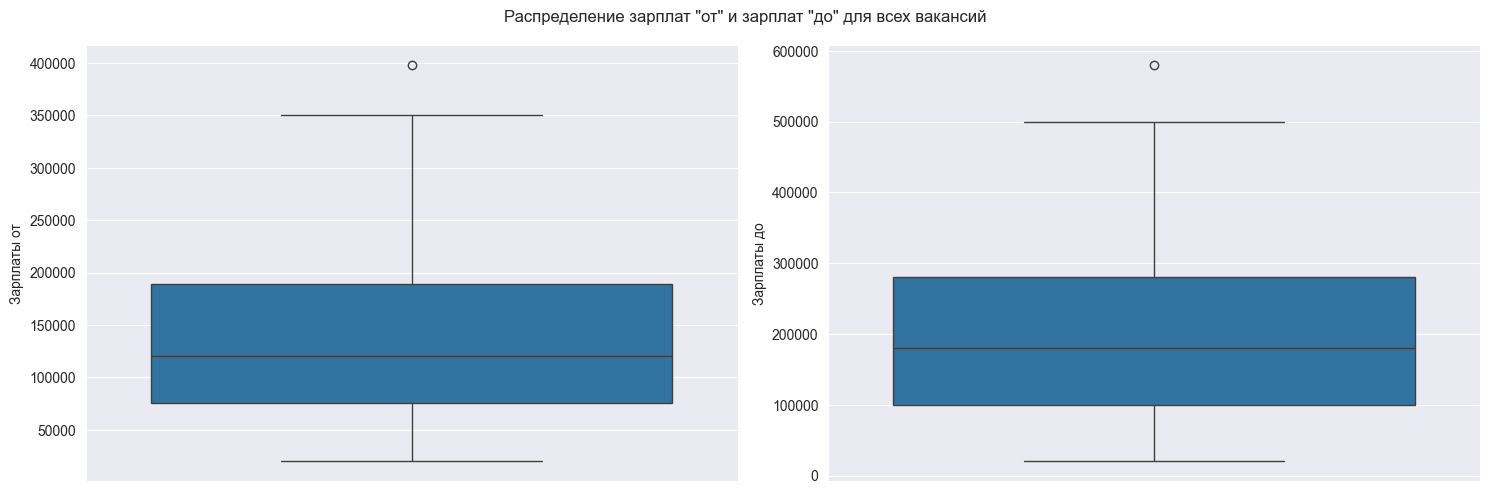

In [32]:
# Посмотрим распределение зарплат на boxplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
for column, ax, label in zip(['salary_from', 'salary_to'],
                      [ax1, ax2],
                      ['Зарплаты от', 'Зарплаты до']):
    ax = sns.boxplot(vacancies[column], ax=ax)
    ax.set_ylabel(label)
fig.suptitle('Распределение зарплат "от" и зарплат "до" для всех вакансий')
plt.tight_layout()
plt.show()

Заметны 2 выброса в зарплатах. Проверим, что это за вакансии в датасете.

In [33]:
vacancies[vacancies['salary_from'] == 398000] 

,name,employer,area,experience,key_skills,schedule,employment,salary_from,salary_to,hard_skills_from_description,soft_skills_from_description,job_type,hard_skills,soft_skills
1436,Data Analyst,Mayflower,Москва,Middle (3-6 years),"[английский язык, коммуникация, sql, a/b тесты...",Полный день,Полная занятость,398000.0,497500.0,юнит-экономика,"коммуникация, критическое мышление",DA,"[sql, data analysis, big data, a/b тесты, юнит...","[коммуникация, английский язык, критическое мы..."


Думаю, что такая вакансия действительно может существовать. Здесь ошибки нет. Можно оставить в датасете.

In [34]:
vacancies[vacancies['salary_to'] == 580000]

,name,employer,area,experience,key_skills,schedule,employment,salary_from,salary_to,hard_skills_from_description,soft_skills_from_description,job_type,hard_skills,soft_skills
2790,Системный аналитик Senior,Offer Now,Москва,Junior+ (1-3 years),[документация],Полный день,Полная занятость,NaN,580000.0,NaN,документация,SA,NaN,[документация]


Здесь идет расхождение между опытом и грейдом в названии вакансии. Ищут сеньора. Вилка соответсвует предложению на рынке. Можно оставить.

## Промежуточные выводы

В процессе предобработки данных мы объединили датасеты для упрощения взаимодействия с данными. Далее мы убрали поля, которые не пригодятся нам для дальнейшего анализа.

После этого мы проверили датасет на наличие явных дубликатов (обнаружили 310) и удалил их.

Проверили поля `employer`, `experience`, `schedule` и `employment` на наличие неявных дубликатов. По итогу проверки данные оставили в первоначальном виде.

Далее мы обогатили данные по хард- и софт-навыкам, разделив списки с навыками и категоризировав их. Пропуски в зарплатах оставили без заполнений, а также обработали аномальные значения.

После обработки данных было удалено строк:

In [35]:
# Проверим процент удаленных данных после всех преобразований
rows_count = (pd.DataFrame({
    'Original rows count': [ORIGIN_ROW_COUNT],
    'Rows count now': [vacancies.shape[SHAPE_ROWS]],
    'Процент удаленных данных': [1 - vacancies.shape[SHAPE_ROWS] / ORIGIN_ROW_COUNT],
}).style
.format({'Процент удаленных данных': '{:.2%}'}))

(rows_count
 .set_properties
 (**{'background-color': 'red',
     'color': 'white',
     'text-align': 'center'},
  subset='Процент удаленных данных'))

,Original rows count,Rows count now,Процент удаленных данных
0,3716,3406,8.34%


__Данные признаны репрезентативными__.

# Исследовательский анализ данных

### Выявление грейда требуемых специалистов по названию вакансии или по колонке с требуемым опытом.

Уберем данные об опыте из поля `experience` и оставим только название грейда.

In [36]:
vacancies['experience'] = vacancies['experience'].str.split(n=1, expand=True).drop(columns=1)
vacancies['experience'].unique()

array(['Junior', 'Junior+', 'Middle', 'Senior'], dtype=object)

In [37]:
# посмотрим список всех уникальных наименований вакансий
vacancies['name'].unique().tolist()

['Junior аналитик данных (исследователь)',
 'Аналитик данных',
 'Аналитик данных (исследователь)',
 'Ведущий аналитик данных',
 'Senior Data Analyst (Цифровой билайн)',
 'Дата аналитик',
 'Data Analyst',
 'Data Analyst / Data Scientist',
 'Продуктовый аналитик / Data Analyst',
 'Data analyst / Аналитик данных',
 'Аналитик данных (Отдел по анализу конкурентов)',
 'Аналитик данных (в офисе)',
 'Data analyst',
 'Аналитик данных в клиентский сервис',
 'Аналитик данных (антифрод)',
 'Аналитик данных (Data Analyst)',
 'Старший аналитик данных (клиентский опыт)',
 'Senior Data Analyst (Ads Platform)',
 'Аналитик данных в Банк',
 'Аналитик данных CV (Северсталь Диджитал)',
 'Старший Аналитик данных в Яндекс Маркет',
 'Аналитик данных (Python)',
 'Data Analyst (Команда Управления Комплаенс)',
 'Senior Data Analyst',
 'Аналитик данных (Data-analyst)',
 'Data Analyst / Аналитик данных (Middle)',
 'Аналитик данных Excel',
 'Senior PPC Data Analyst',
 'Senior Data Analyst (Pharma) / Старший аналити

В названиях вакансий встречаются упоминания грейдов. Здесь стоит отметить, что градация грейдов достаточно размытая и у каждой компании есть свои представления о ней, поэтому мне кажется, что по возможности лучше учитывать грейды, которые указаны в названии вакансии. Поэтому если грейд в названии выше, чем грейд в требуемом опыте, то лучше учитывать грейд из названия.

In [38]:
def get_grade(row) -> str:
    """Функция сравнивает грейды в названиях и
    в требуемом опыте и возвращает наиболее подходящий грейд."""
    top_grades = {
        'Junior': 1,
        'Junior+': 2,
        'Middle': 3,
        'Senior': 4,
    }
    name = row['name'].lower()
    exp = row['experience']
    grade = None
    if 'junior' in name:
        grade = 'Junior'
    elif 'junior+' in name:
        grade = 'Junior+'
    elif 'middle' in name or 'мидл' in name or 'lead' in name:
        grade = 'Middle'
    elif 'senior' in name:
        grade = 'Senior'
    else:
        return exp
    return grade if top_grades[grade] > top_grades[exp] else exp

In [39]:
# Создадим поле с грейдами
vacancies['grade'] = vacancies.apply(get_grade, axis=1)
# Проверка
vacancies.loc[vacancies['grade'] != vacancies['experience'], ['name', 'experience', 'grade']].head(10)

,name,experience,grade
5,Senior Data Analyst (Цифровой билайн),Middle,Senior
23,Senior Data Analyst (Ads Platform),Middle,Senior
32,Senior Data Analyst,Junior+,Senior
36,Data Analyst / Аналитик данных (Middle),Junior+,Middle
38,Senior PPC Data Analyst,Middle,Senior
39,Senior Data Analyst (Pharma) / Старший аналити...,Middle,Senior
95,Аналитик данных (Middle) в службу управления д...,Junior+,Middle
109,Middle Data Analyst NLP/SberProfile,Junior+,Middle
115,Senior Data Analyst / Ведущий аналитик данных,Middle,Senior
131,Аналитик данных (мидл),Junior+,Middle


Данные получили более адекватное представление.

In [40]:
# Удалим столбцы, которые не понадобятся для дальнейшего анализа
vacancies = vacancies.drop(columns=['name', 'experience', 'key_skills',
                                    'hard_skills_from_description', 'soft_skills_from_description'])
vacancies.head()

,employer,area,schedule,employment,salary_from,salary_to,job_type,hard_skills,soft_skills,grade
0,DNS Головной офис,Владивосток,Полный день,Полная занятость,60000.0,NaN,DA,"[python, power bi, субд, sql]",NaN,Junior
1,Комус,Москва,Полный день,Полная занятость,NaN,NaN,DA,"[ms sql, работа с базами данных, ms excel]",NaN,Junior
2,DNS Головной офис,Владивосток,Полный день,Полная занятость,90000.0,NaN,DA,"[sql, clickhouse, субд, power bi, bpmn, python]",NaN,Junior+
3,Х5 Group,Москва,Полный день,Полная занятость,NaN,NaN,DA,"[анализ данных, pandas, аналитика, sql, работа...","[деловая коммуникация, коммуникация]",Junior+
4,ЛУКОЙЛ,Москва,Полный день,Полная занятость,NaN,NaN,DA,NaN,[документация],Middle


### Определение доли грейдов Junior, Junior+, Middle, Senior среди вакансий Аналитик данных и Системный аналитик.

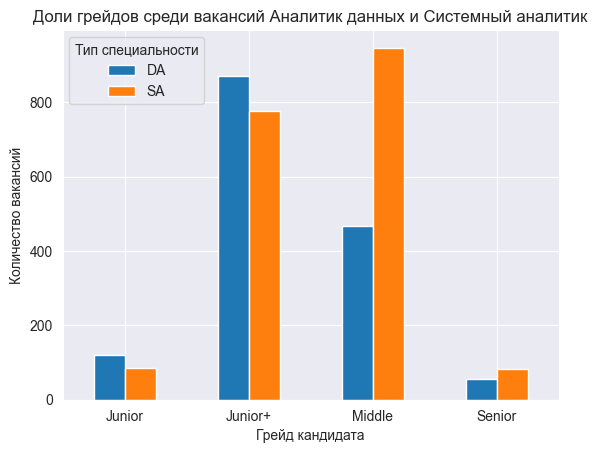

In [41]:
grades_per_job_types = vacancies.pivot_table(index='grade', columns='job_type', values='area', aggfunc='count')
grades_per_job_types.plot(kind='bar')
plt.ylabel('Количество вакансий')
plt.xlabel('Грейд кандидата')
plt.xticks(rotation=0)
plt.title('Доли грейдов среди вакансий Аналитик данных и Системный аналитик')
plt.legend(title='Тип специальности', loc=2)
plt.show()

Можно заметить, что больше всего вакансий для грейдов `Junior+` И `Middle` как у Аналитиков данных, так и у Системных аналитиков. При этом по абсолютным показателям наибольшее число вакансий приходится на Middle Системного аналитика (~900). Чуть меньше вакансий у Junior+ (около 850) Аналитика данных. Меньше всего вакансий для `Senior` и `Junior` как у Аналитиков данных, так и Системных аналитиков.

### Определение типичного места работы для Аналитика данных и Системного аналитика по следующим параметрам: ТОП-работодателей, зарплата, тип занятости, график работы.

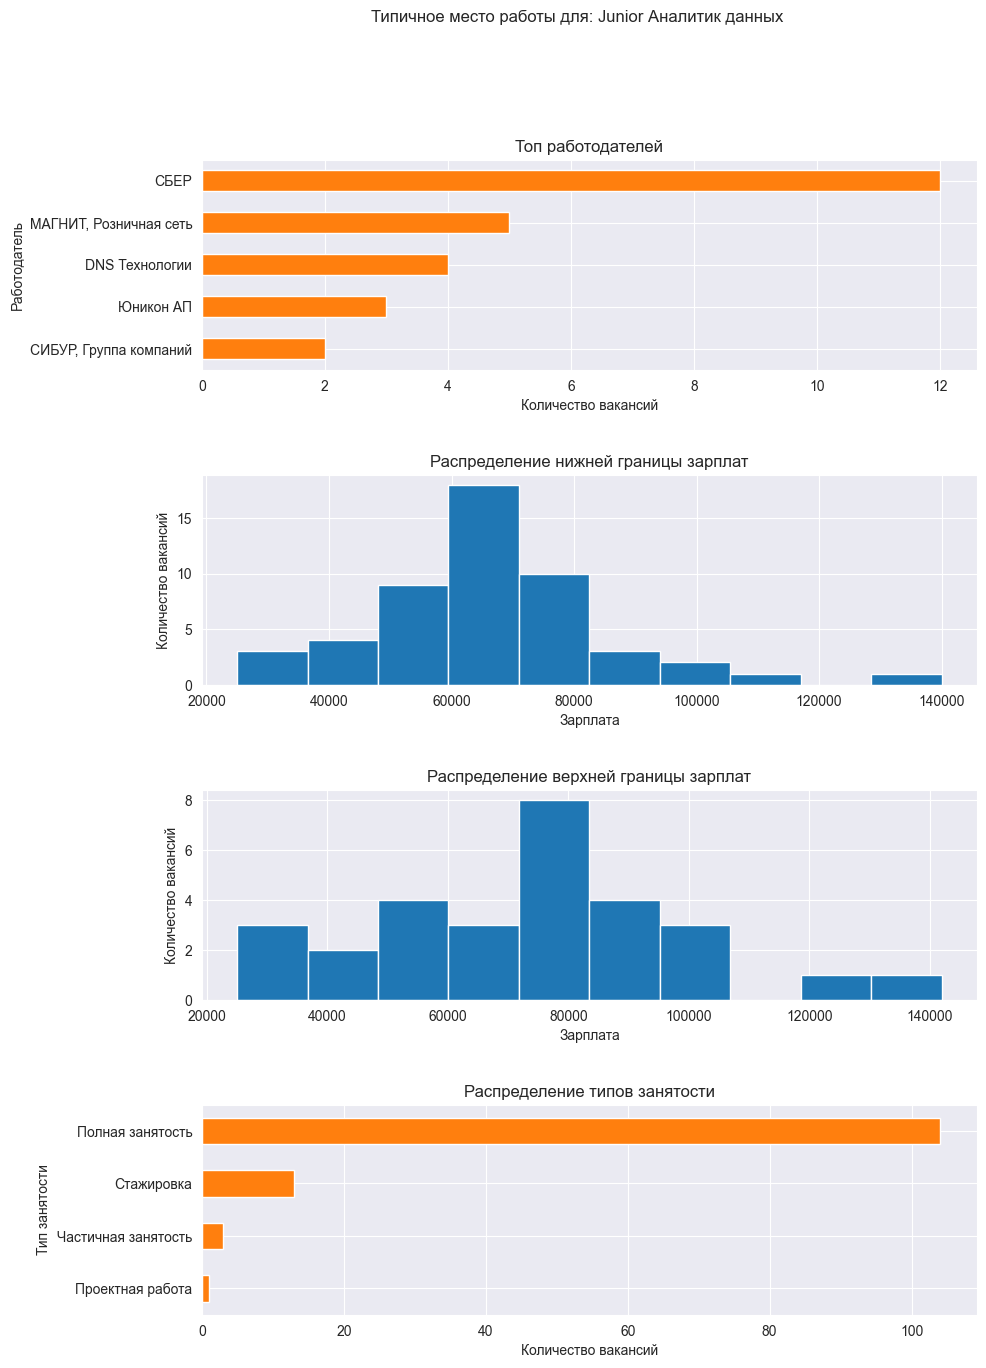

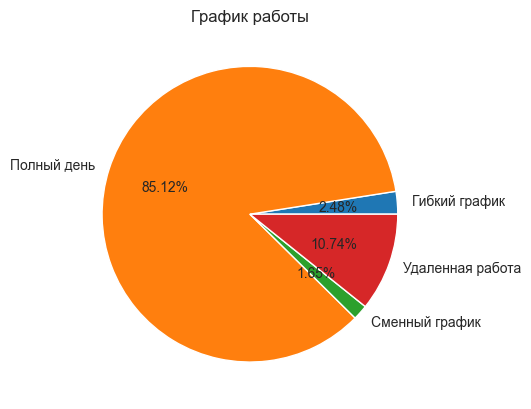

In [42]:
def visualize_common_workplace(job_type: str, grade: str):
    """Создает графики распределений вакансий по столбцам
    employer, salary_from, salary_to, employment, schedule
    для определения типичного места работы Аналитика данных
    или Системного аналитика."""
    PLOT_INFO = {
        'DA': 'Аналитик данных',
        'SA': 'Системный аналитик',
        'employer': {
            'title': 'Топ работодателей',
            'ylabel': 'Работодатель',
        },
        'employment': {
            'title': 'Распределение типов занятости',
            'ylabel': 'Тип занятости',
        },
        'salary_from': {
            'title': 'Распределение нижней границы зарплат',
        },
        'salary_to': {
            'title': 'Распределение верхней границы зарплат',
        },
    }

    fig = plt.figure(figsize=(10, 15))
    for i, column in enumerate(['employer', 'salary_from',
                                'salary_to', 'employment', 'schedule'],
                               start=1):
        common_work = (vacancies[(vacancies['grade'] == grade)
                       & (vacancies['job_type'] == job_type)])

        if column == 'salary_from' or column == 'salary_to':
            common_work[column].hist(ax=plt.subplot(4, 1, i))
            plt.title(f'{PLOT_INFO[column]["title"]}')
            plt.ylabel('Количество вакансий')
            plt.xlabel('Зарплата')
            continue

        common_work = common_work.pivot_table(index=column,
                                              values='area',
                                              aggfunc='count')
        if column == 'schedule':
            common_work.plot(kind='pie',
                             subplots=True,
                             autopct='%.2f%%',
                             legend=False)
            plt.ylabel('')
            plt.title('График работы')
        else:
            common_work.sort_values(by='area').tail(5).plot(kind='barh',
                                                            ax=plt.subplot(4, 1, i),
                                                            color='tab:orange',
                                                            legend=False)
            plt.suptitle(f'Типичное место работы для: {grade} {PLOT_INFO[job_type]}')
            plt.title(f'{PLOT_INFO[column]["title"]}')
            plt.xlabel('Количество вакансий')
            plt.ylabel(f'{PLOT_INFO[column]["ylabel"]}')
            plt.subplots_adjust(hspace=0.5)
    plt.show()


# Визуализация для junior DA
visualize_common_workplace('DA', 'Junior')

__Типичное место работы для junior Аналитика данных:__
1) Работодатель: СБЕР
2) Зарплата от 60.000 до 80.000 тыс. руб.
3) Занятость: Полная занятость
4) График работы: Полный день

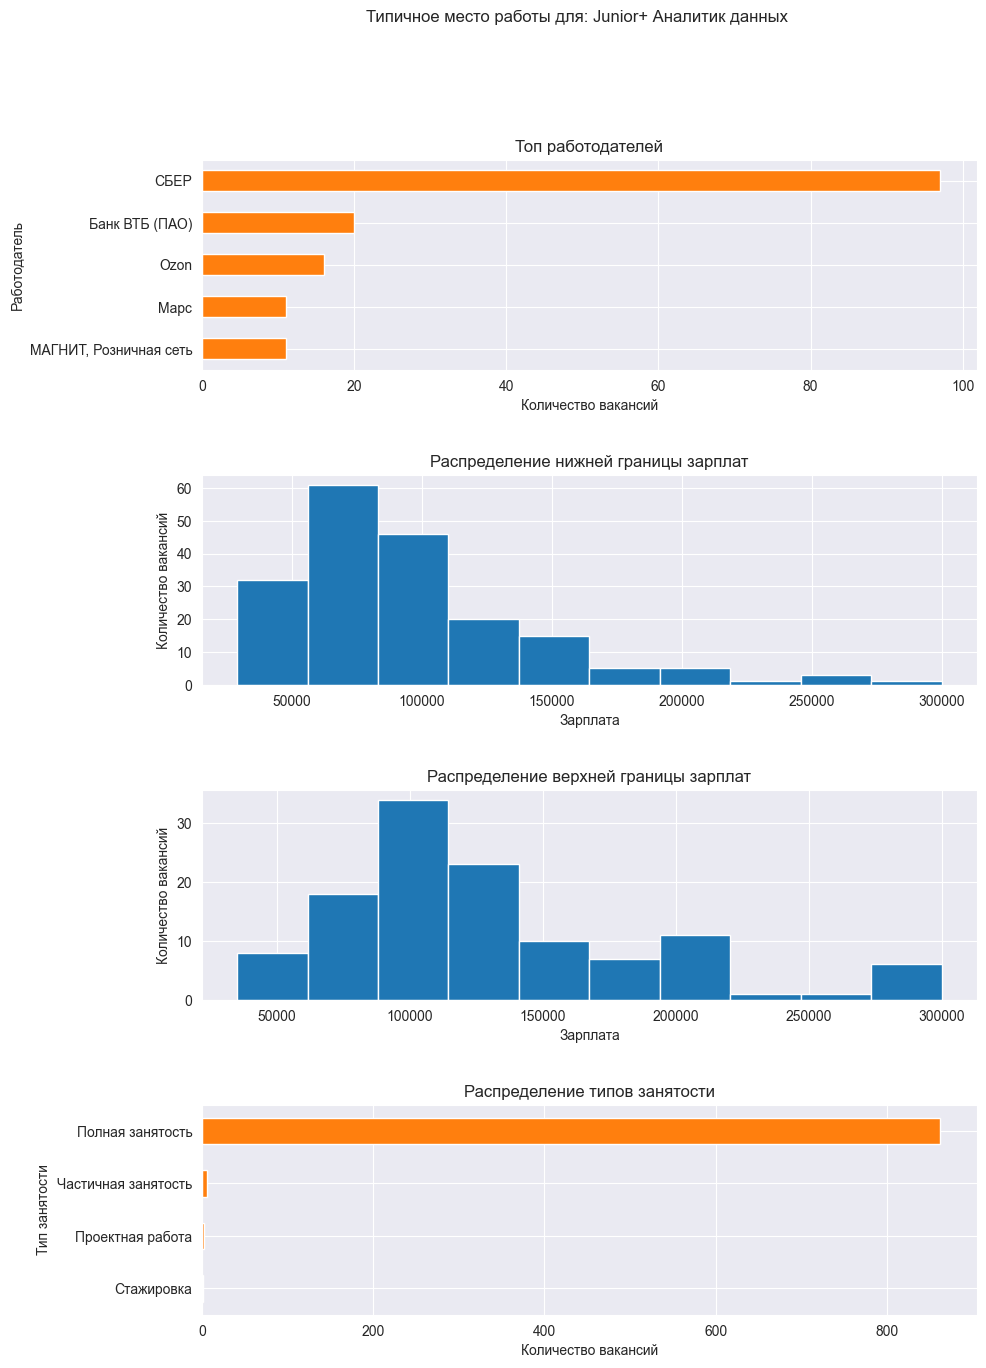

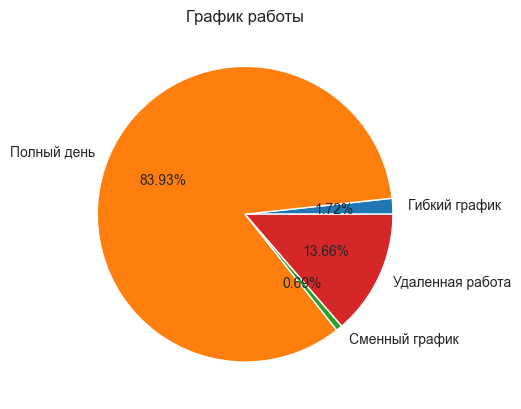

In [43]:
# Визуализация для junior+ DA
visualize_common_workplace('DA', 'Junior+')

__Типичное место работы для junior+ Аналитика данных:__
1) Работодатель: СБЕР
2) Зарплата от ~75.000 до 100.000 тыс. руб.
3) Занятость: Полная занятость
4) График работы: Полный день

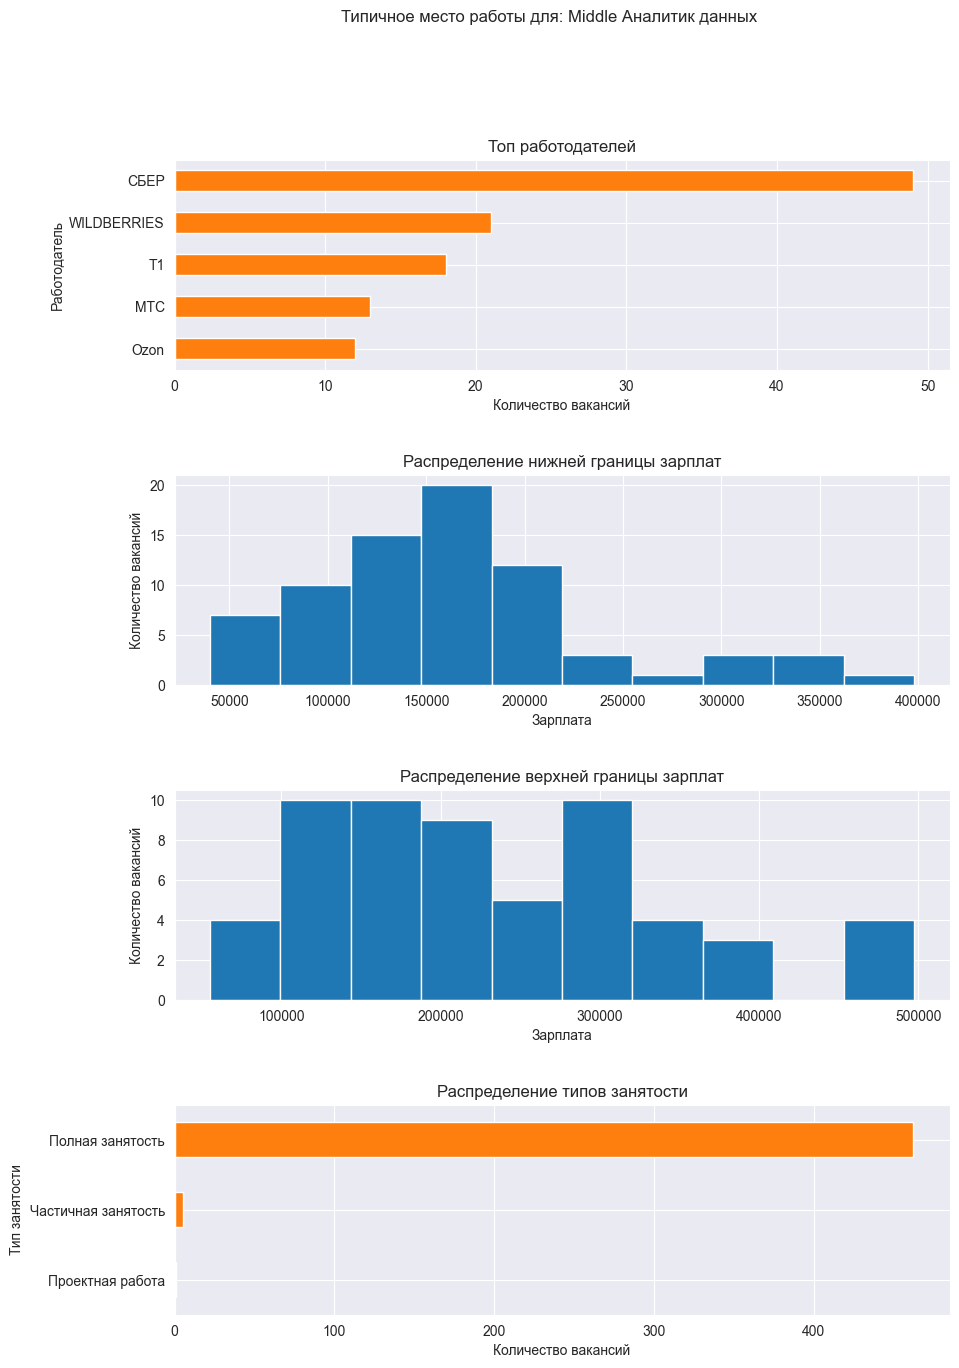

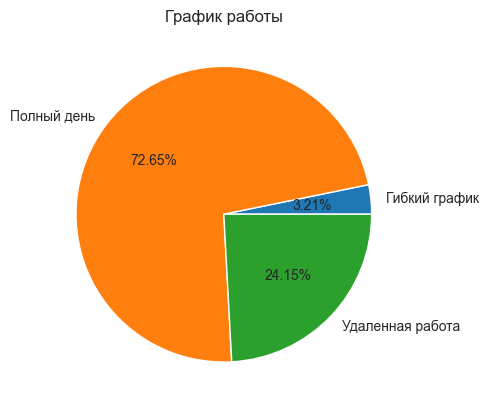

In [44]:
# Визуализация для middle DA
visualize_common_workplace('DA', 'Middle')

__Типичное место работы для middle Аналитика данных:__
1) Работодатель: СБЕР
2) Зарплата от 160.000, может доходить до 300.000 тыс. руб.
3) Занятость: Полная занятость
4) График работы: Полный день, но в некоторых случаях могут предложить удаленную работу.

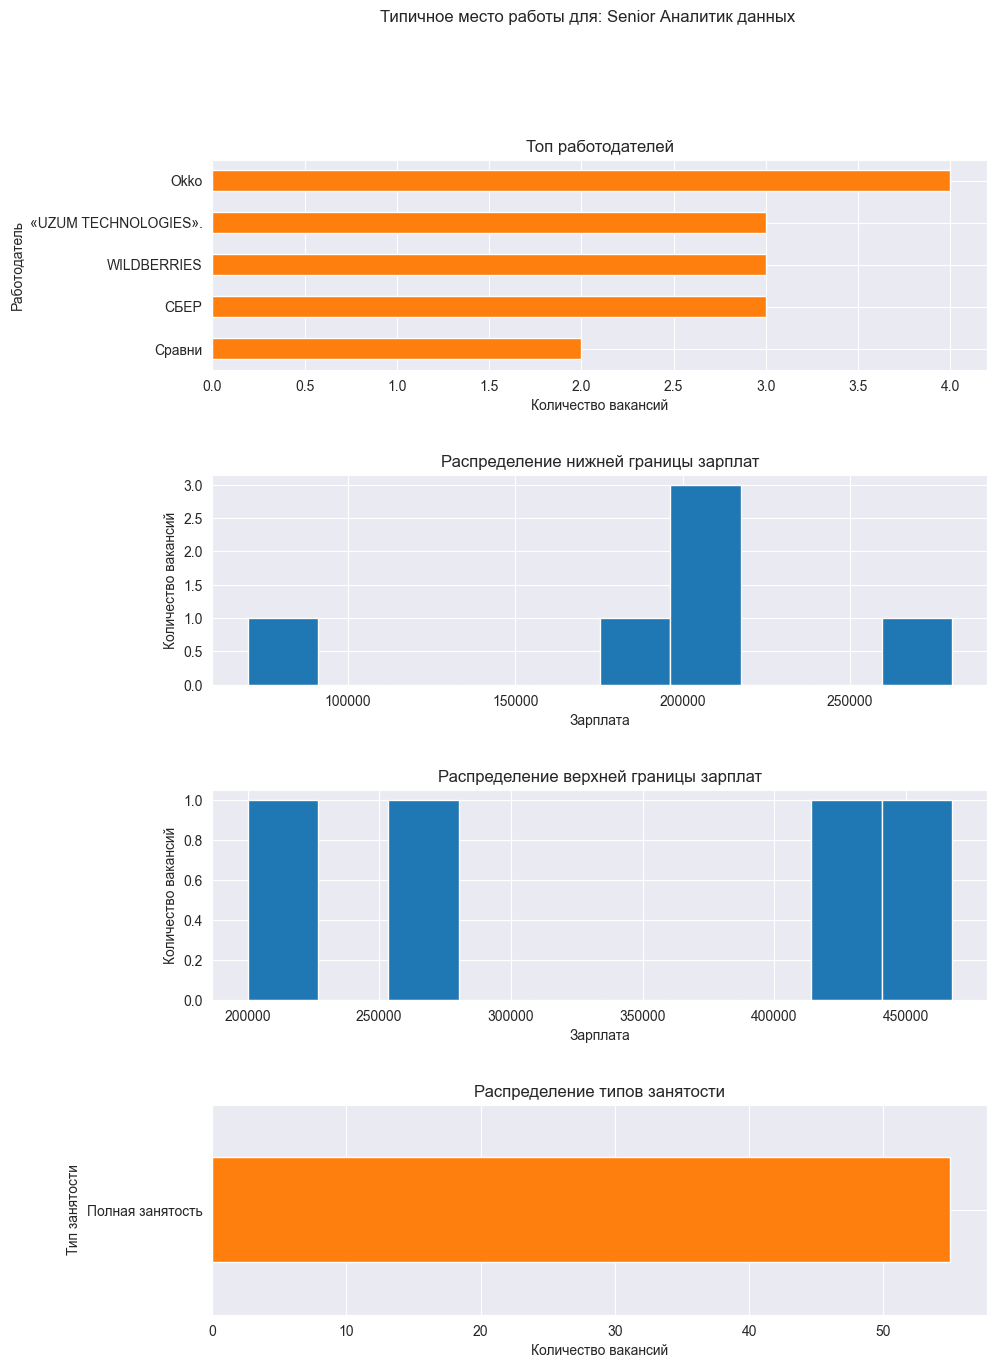

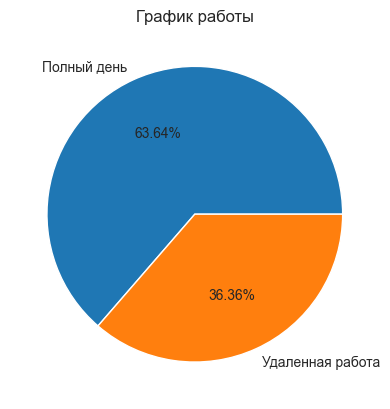

In [45]:
# Визуализация для senior DA
visualize_common_workplace('DA', 'Senior')

__Типичное место работы для senior Аналитика данных:__
1) Работодатель: Okko
2) Зарплата от 200.000, может доходить до 450.000 тыс. руб.
3) Занятость: исключительно Полная занятость
4) График работы: Полный день либо удаленная работа.

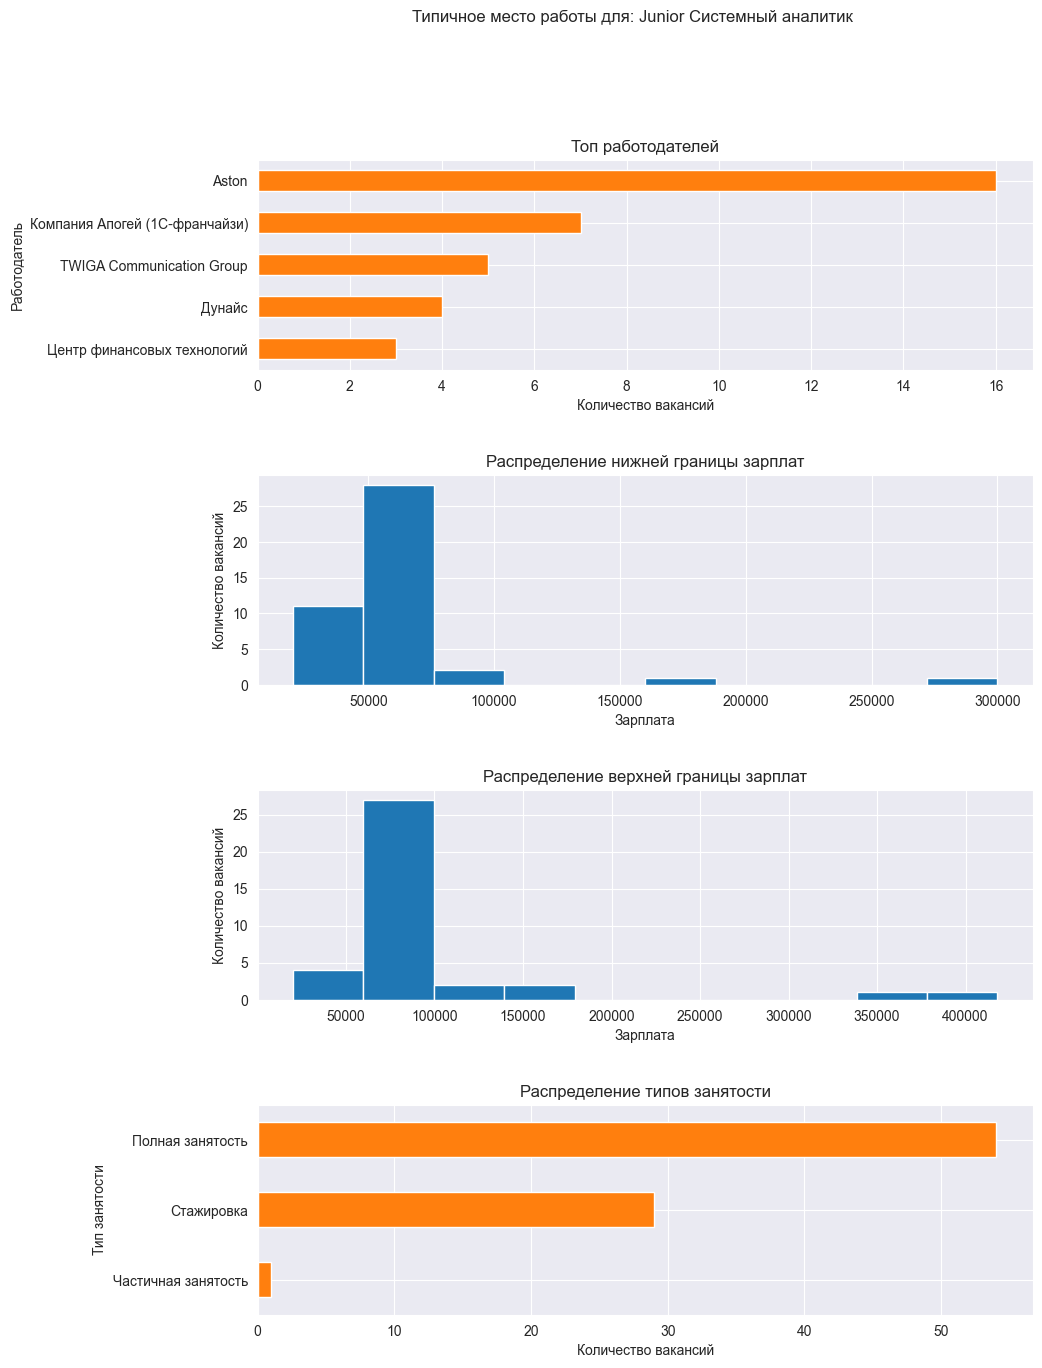

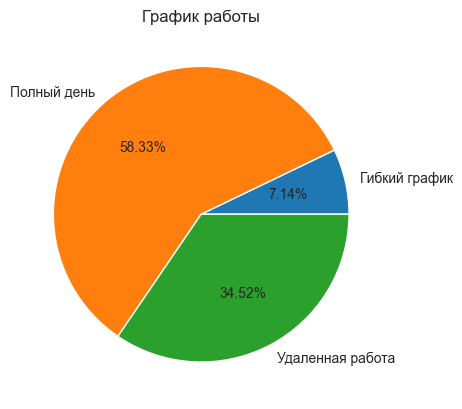

In [46]:
# Визуализация для junior SA
visualize_common_workplace('SA', 'Junior')

__Типичное место работы для junior Системного аналитика:__
1) Работодатель: Aston
2) Зарплата от 60.000 до ~75.000 тыс. руб.
3) Занятость: Полная занятость
4) График работы: Полный день, но могут предложить удаленную работу.

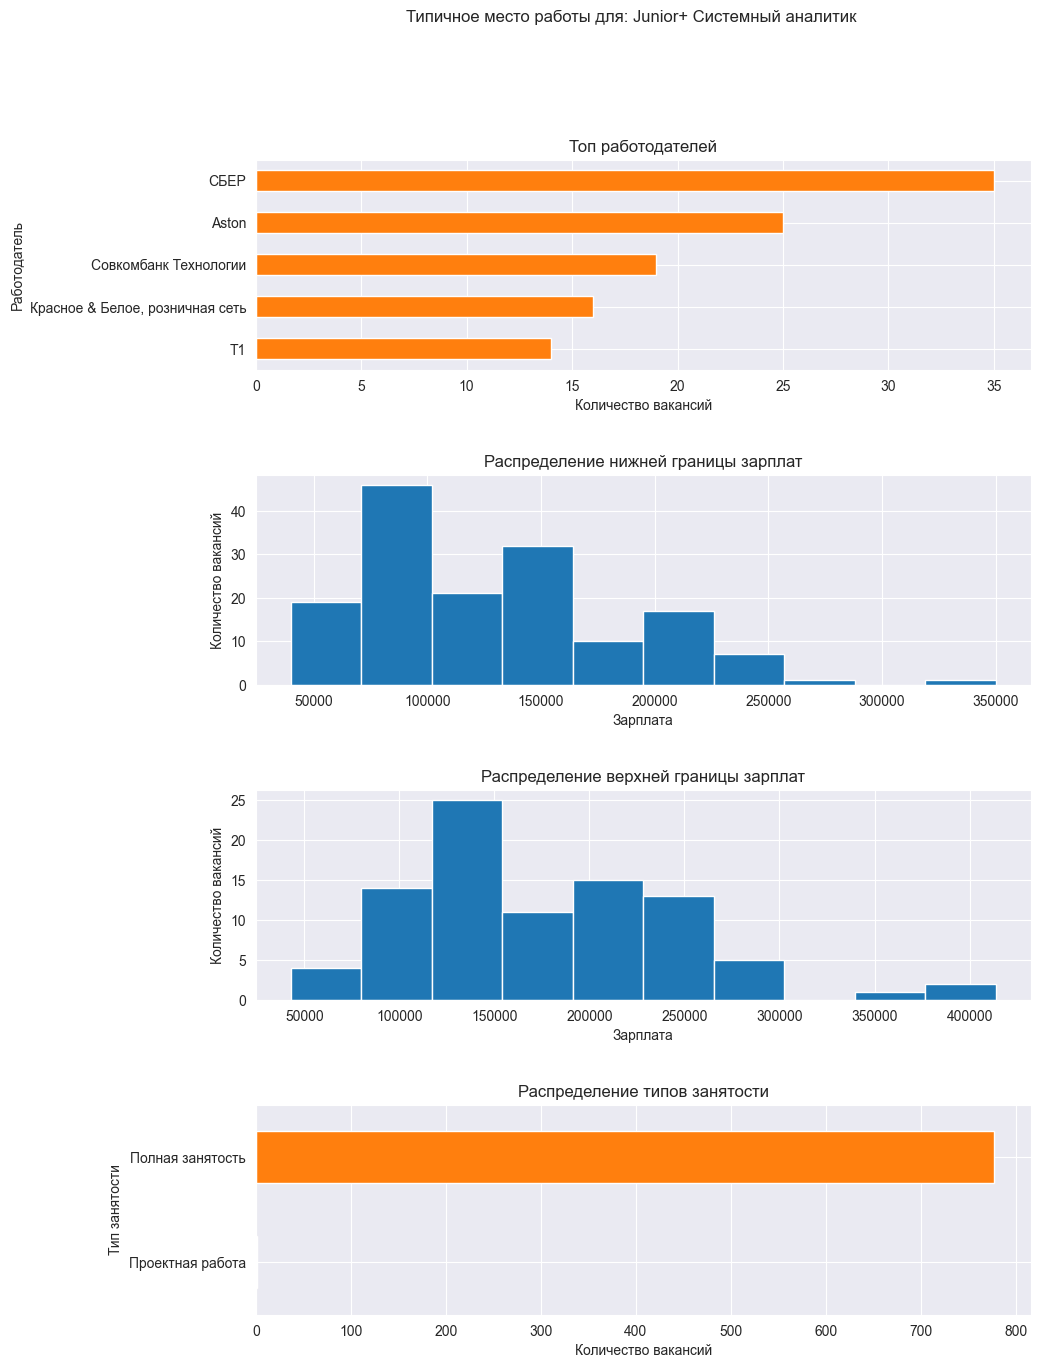

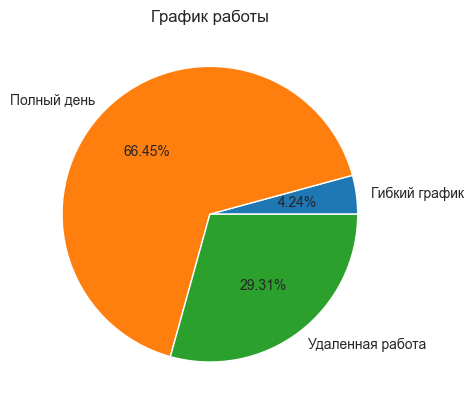

In [47]:
# Визуализация для junior+ SA
visualize_common_workplace('SA', 'Junior+')

__Типичное место работы для junior+ Системного аналитика:__
1) Работодатель: СБЕР
2) Зарплата от ~75.000 до ~130.000 тыс. руб.
3) Занятость: Полная занятость
4) График работы: Полный день, но могут предложить удаленную работу

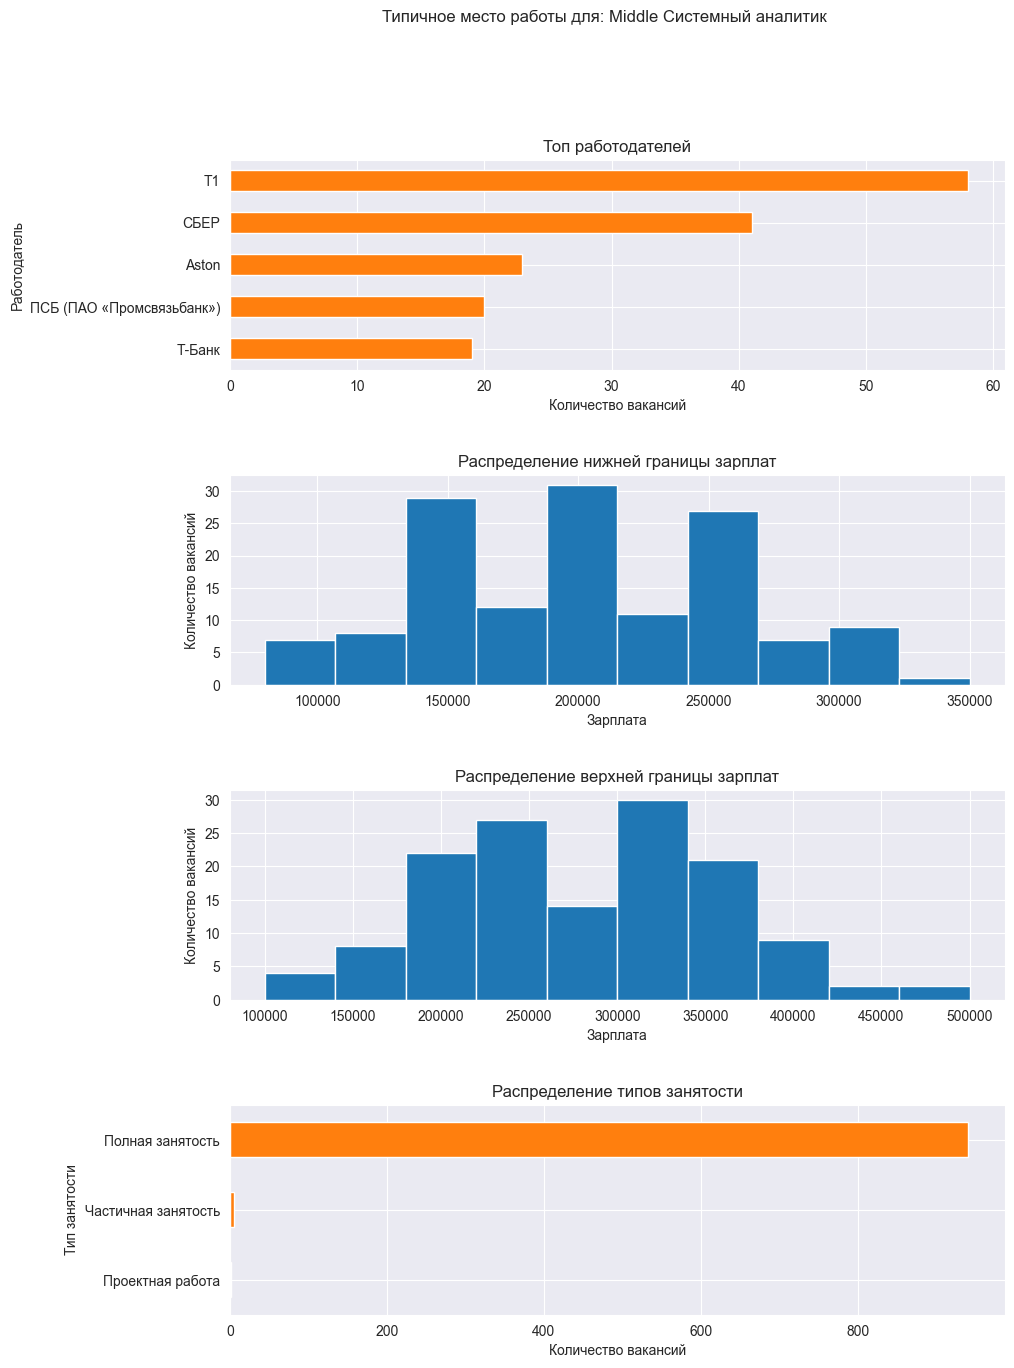

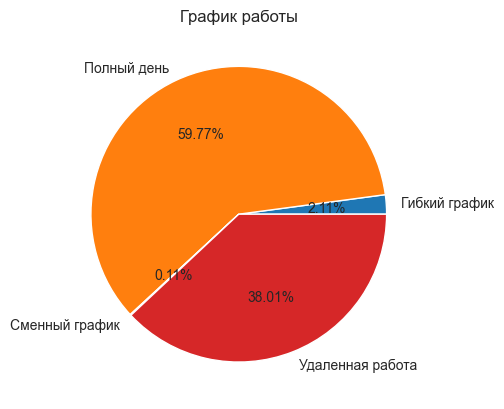

In [48]:
# Визуализация для middle SA
visualize_common_workplace('SA', 'Middle')

__Типичное место работы для middle Системного аналитика:__
1) Работодатель: T1
2) Зарплата от ~200.000 до ~325.000 тыс. руб.
3) Занятость: Полная занятость
4) График работы: Полный день, но могут предложить удаленную работу

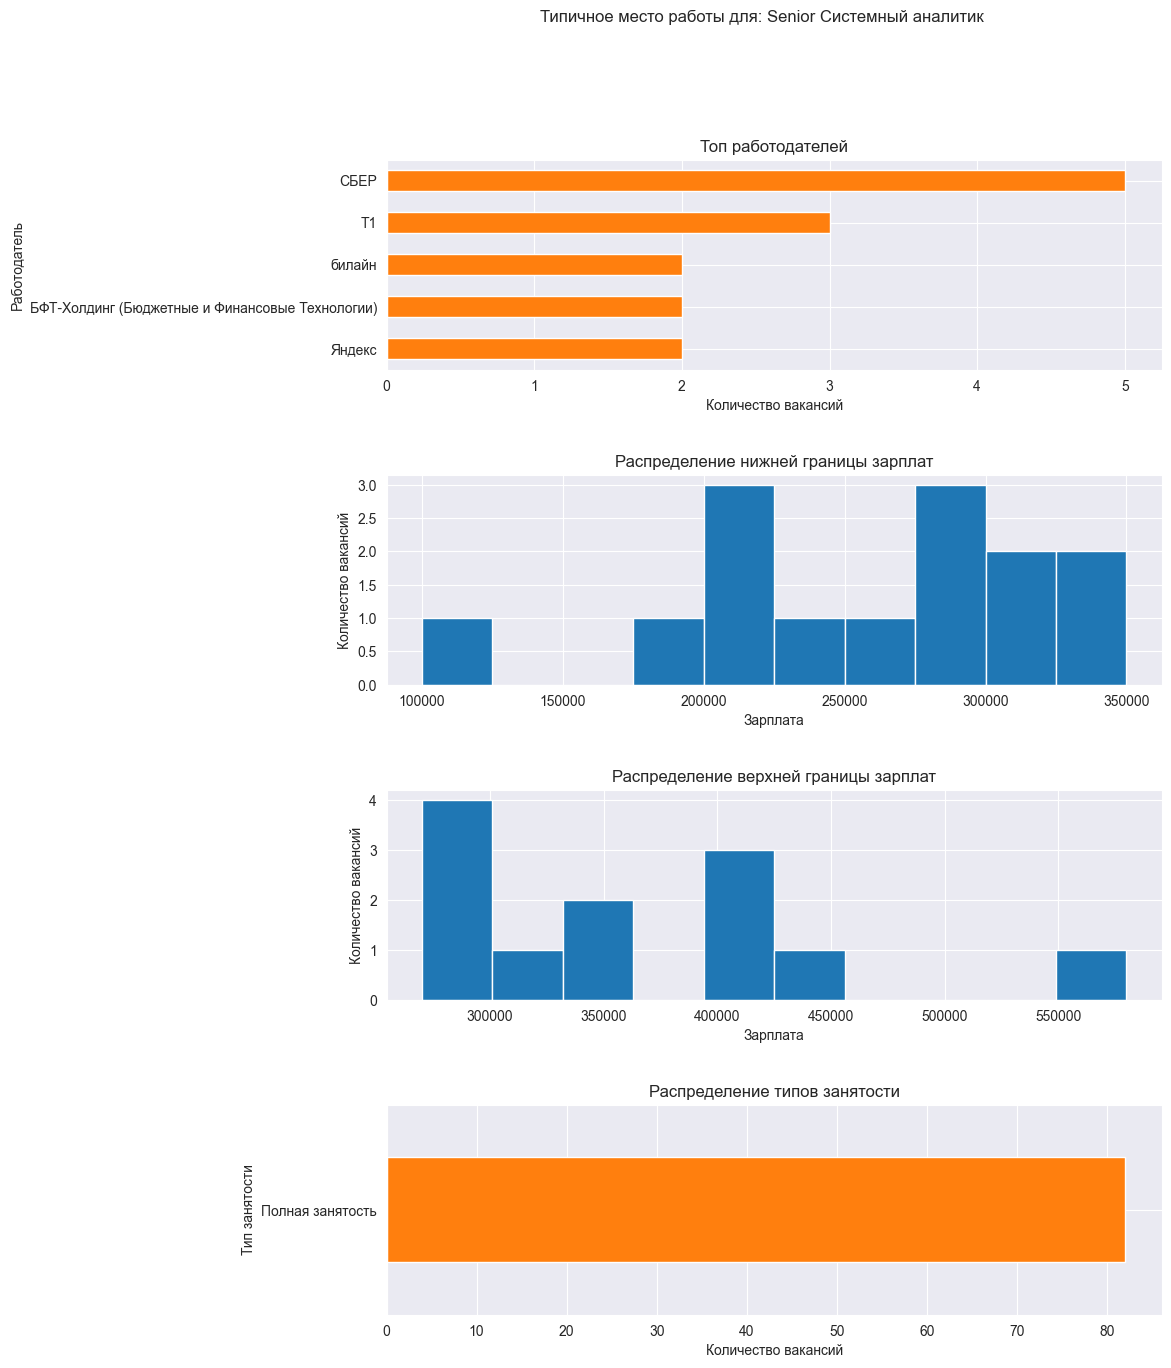

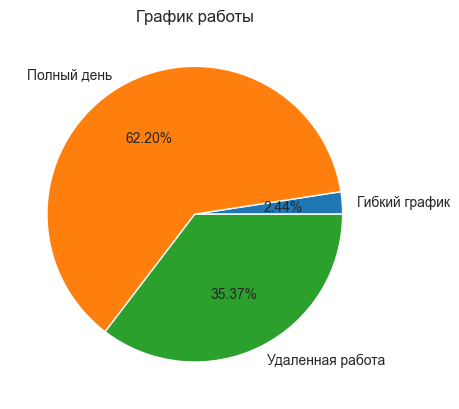

In [49]:
# Визуализация для senior SA
visualize_common_workplace('SA', 'Senior')

__Типичное место работы для senior Системного аналитика:__
1) Работодатель: СБЕР
2) Зарплата от ~275.000 до ~400.000 тыс. руб.
3) Занятость: Полная занятость
4) График работы: Полный день, но могут предложить удаленную работу

### Определить, какие навыки спрашивают чаще - твердые или мягкие. К какому грейду и к какой специальности требований больше.

In [50]:
# Напишем функцию, которая посчитает
# количество навыков в списках
def get_skills_count(skills_list):
    """Функция считает количество навыков
    в списках навыков."""
    if isinstance(skills_list, float):
        return np.nan
    return len(skills_list)


vacancies['hard_skills_count'] = vacancies['hard_skills'].apply(get_skills_count)
vacancies['soft_skills_count'] = vacancies['soft_skills'].apply(get_skills_count)
# Проверка
vacancies.head(10)

,employer,area,schedule,employment,salary_from,salary_to,job_type,hard_skills,soft_skills,grade,hard_skills_count,soft_skills_count
0,DNS Головной офис,Владивосток,Полный день,Полная занятость,60000.0,NaN,DA,"[python, power bi, субд, sql]",NaN,Junior,4.0,NaN
1,Комус,Москва,Полный день,Полная занятость,NaN,NaN,DA,"[ms sql, работа с базами данных, ms excel]",NaN,Junior,3.0,NaN
2,DNS Головной офис,Владивосток,Полный день,Полная занятость,90000.0,NaN,DA,"[sql, clickhouse, субд, power bi, bpmn, python]",NaN,Junior+,6.0,NaN
3,Х5 Group,Москва,Полный день,Полная занятость,NaN,NaN,DA,"[анализ данных, pandas, аналитика, sql, работа...","[деловая коммуникация, коммуникация]",Junior+,9.0,2.0
4,ЛУКОЙЛ,Москва,Полный день,Полная занятость,NaN,NaN,DA,NaN,[документация],Middle,NaN,1.0
5,билайн,Москва,Удаленная работа,Полная занятость,NaN,NaN,DA,"[python, математическая статистика, sql]",NaN,Senior,3.0,NaN
6,ГКУ Центр занятости населения города Москвы,Москва,Полный день,Полная занятость,100000.0,NaN,DA,NaN,NaN,Junior+,NaN,NaN
7,СБЕР,Санкт-Петербург,Полный день,Полная занятость,NaN,NaN,DA,NaN,"[коммуникация, проактивность, документация]",Junior+,NaN,3.0
8,МТС,Казань,Полный день,Полная занятость,72000.0,NaN,DA,NaN,NaN,Junior+,NaN,NaN
9,Россети Урал,Екатеринбург,Полный день,Полная занятость,51000.0,NaN,DA,NaN,[аналитическое мышление],Junior+,NaN,1.0


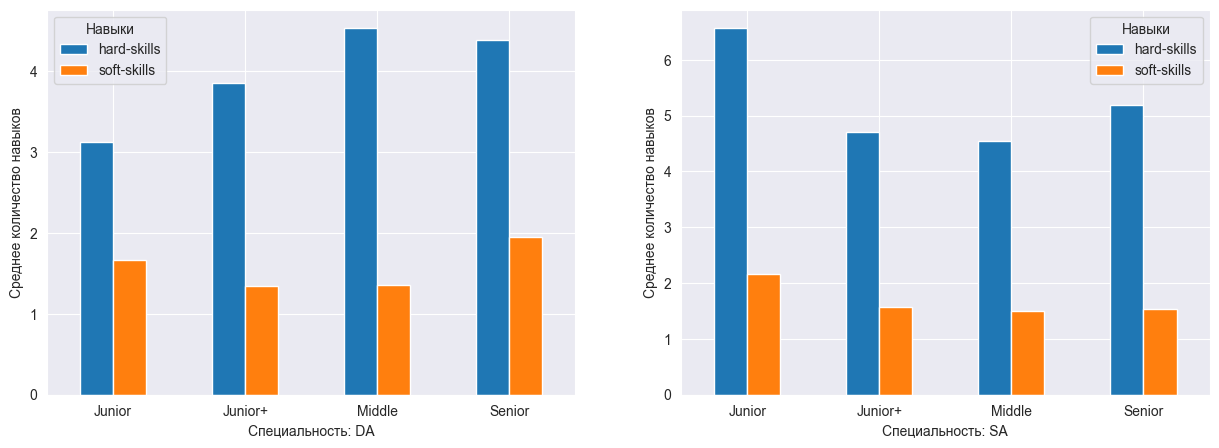

In [51]:
# Построим графики
plt.figure(figsize=(15, 5))
for i, job in enumerate(['DA', 'SA'], start=1):
    skills_count_per_job_type = vacancies[vacancies['job_type'] == job].pivot_table(
        index='grade',
        columns='job_type',
        values=['hard_skills_count', 'soft_skills_count'],
        aggfunc='mean',
    )
    ax = skills_count_per_job_type.plot(kind='bar',
                                        ax=plt.subplot(1, 2, i))
    
    ax.set_xlabel(f'Специальность: {job}')
    ax.set_ylabel(f'Cреднее количество навыков')
    ax.legend(['hard-skills', 'soft-skills'], title='Навыки')
    plt.xticks(rotation=0)

plt.show()

По всем вакансиям и по всем грейдам прослеживается тенденция, что требований к Hard-навыкам больше, чем требований к Soft-навыкам. Причем стоит заметить, что в абсолютных значениях требования к hard-навыкам у системных аналитиков выше. Например, это хорошо заметно у junior-специалистов.

Системный аналитик этого грейда в среднем должен владеть 6 hard-навыками, в то время как Аналитик данных того же грейда должен обладать всего 3 hard-навыками. Также отмечу, что у системных аналитиков с повышением герйда в среднем становится меньше требований к навыкам. Однако здесь стоить отметить, что мы распредляли навыки в зависимости от частоты вхождения, поэтому скорее всего, что в вакансиях старших грейдов пристуствуют специфические требования к навыкам, которые мы не учли.

### Определение наиболее желаемых кандидатов на вакансии Аналитик данных и Системный аналитик по следующим параметрам: самые важные hard-skils, самые важные soft-skils.

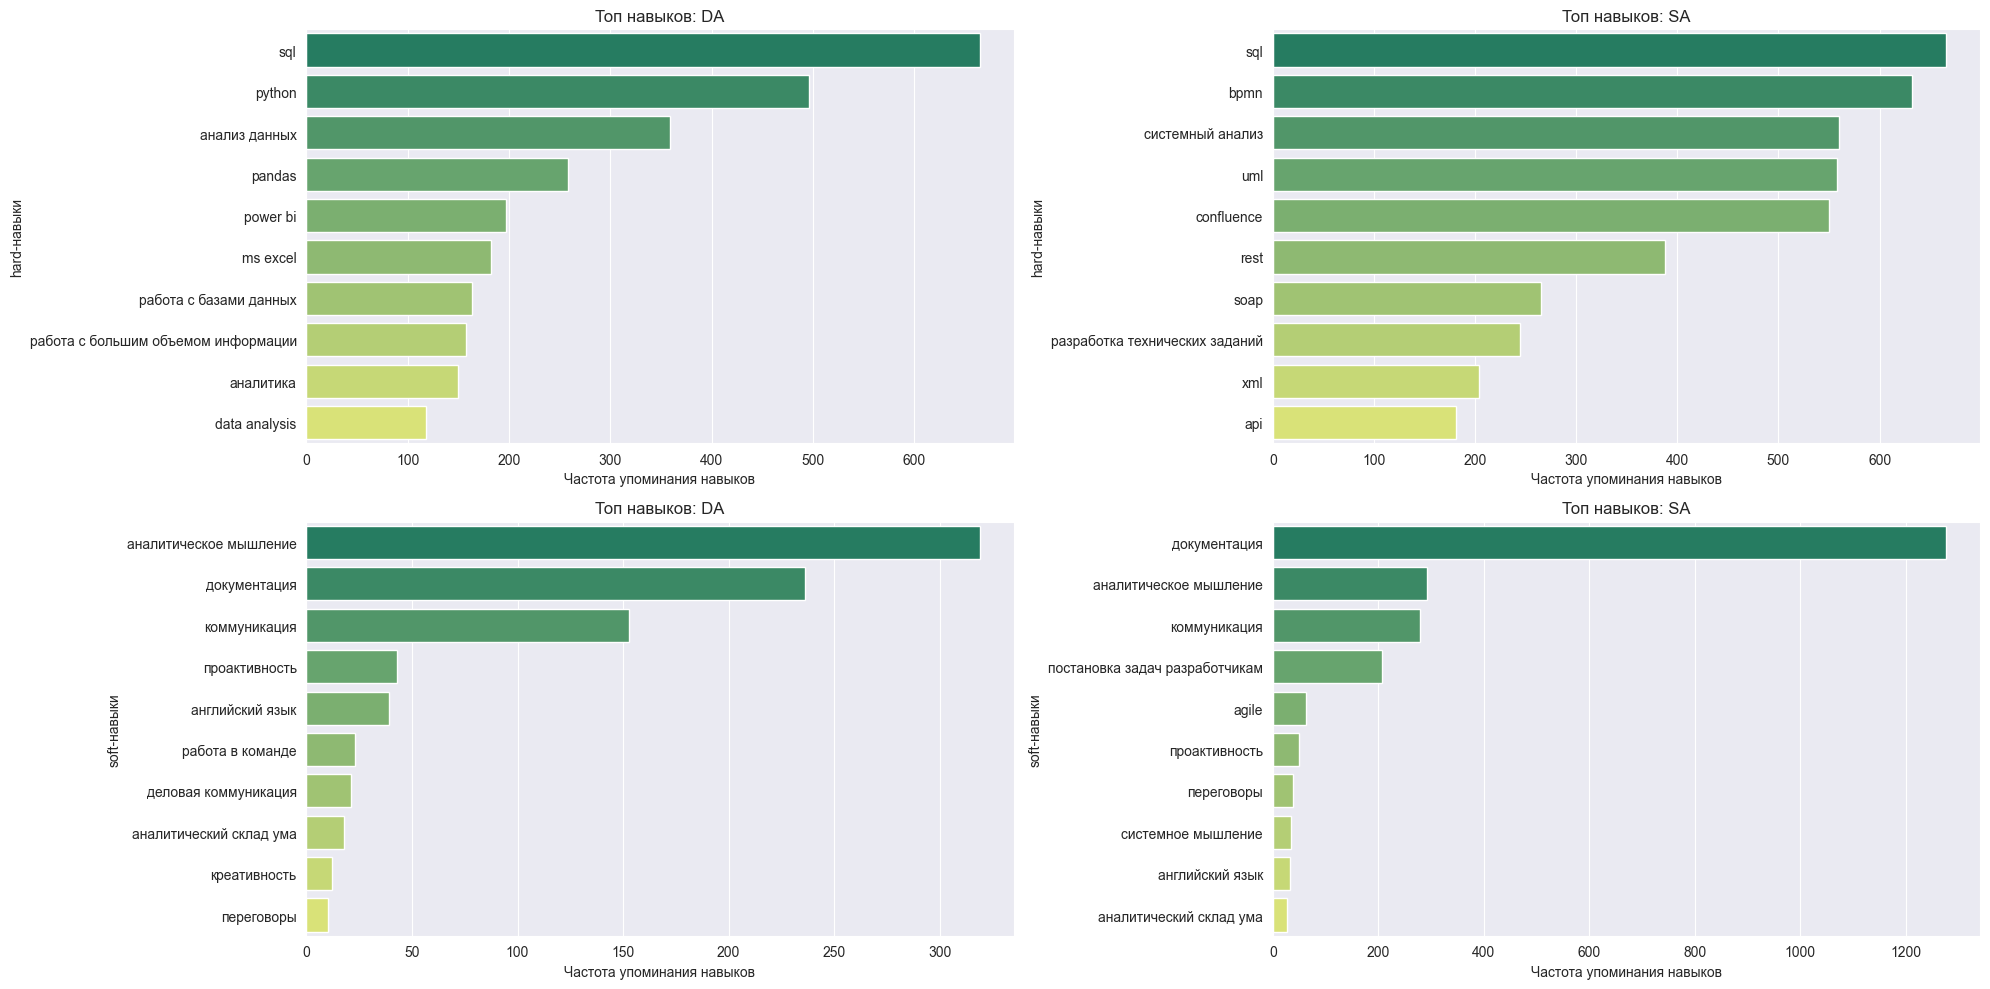

In [52]:
# Разобьем списки с навыками на отдельные строки в датафрейме
hard_skills_df = vacancies.explode('hard_skills')
soft_skills_df = vacancies.explode('soft_skills')

# Построим графики
plt.figure(figsize=(20, 10))
i = 1
for df, column in ((hard_skills_df, 'hard_skills'), (soft_skills_df, 'soft_skills')):
    for job_type in ('DA', 'SA'):
        skills_pivot = (df[df['job_type'] == job_type].pivot_table(
            index=column,
            columns='job_type',
            values='area',
            aggfunc='count'
        ).sort_values(by=job_type, ascending=False))
        ax = sns.barplot(skills_pivot.head(10),
                         y=column,
                         x=job_type,
                         orient='h',
                         ax=plt.subplot(2, 2, i),
                         palette='summer')
        ax.set_xlabel('Частота упоминания навыков')
        ax.set_title(f'Топ навыков: {job_type}')
        if i > 2:
            ax.set_ylabel('soft-навыки')
        else:
            ax.set_ylabel('hard-навыки')

        i += 1
plt.tight_layout()
plt.show()

Из графиков можно сделать следующий вывод:

1. По hard-навыкам.

Топ-5 требуемых навыков у Аналитиков данных:
- SQL,
- Python,
- Анализ Данных,
- pandas,
- PowerBI.

Топ-5 требуемых навыков у Системных аналитиков:
- SQL,
- BPMN,
- Системный анализ,
- uml,
- confluence.

Стоит отметить, пятерка навыков у Системных аналитиков равномернее распределена, чем у Аналитиков Данных. То есть в большинстве вакансий необходимо обладать всеми навыками для соответствия требованиям вакансии. В то время как у Аналитиков данных четко выделяются только SQL, Python и анализ данных. При этом знания SQL необходимы и обязательны для обеих профессий в большинстве вакансий.

2. По soft-навыкам.

Топ-3 требуемых навыков у Аналитиков данных:
- Аналитическое мышление,
- Документация,
- Коммуникация.

Топ-4 требуемых навыков для Системных аналитиков:
- Документация,
- Аналитическое мышление,
- Коммуникация,
- Постановка задач разработчикам.

Здесь необходимо обратить внимание на то, что у системных аналитиков явно выделяется один навык - Документация (Больше 1200 упоминаний.). Оставшиеся навыки хоть и присутствуют в значительной части вакансий, однако относительно навыка "Документация" их доля не так велика. У Аналитиков данных наиболее ценится аналитическое мышление, чуть реже документация. Коммуникация встречается в вакансиях в 2 раза реже чем Аналитическое мышление.

# Общий вывод

Исследовав вакансии Аналитика данных и Системного аналитика с сайта hh.ru, можно прийти к следующим выводам:

1. Предобработка данных

В процессе предобработки данных мы объединили датасеты для упрощения взаимодействия с данными. Далее мы убрали поля, которые не пригодятся нам для дальнейшего анализа.

После этого мы проверили датасет на наличие явных дубликатов (обнаружили 310) и удалили их.

Проверили поля `employer`, `experience`, `schedule` и `employment` на наличие неявных дубликатов. По итогу проверки данные оставили в первоначальном виде.

Далее мы обогатили данные по хард- и софт-навыкам, разделив списки с навыками и категоризировав их. Пропуски в зарплатах оставили без заполнений, а также обработали аномальные значения.

2. Исследовательский анализ данных:
- __Доли грейдов в вакансиях:__

Наиболее часто встречающиеся грейды в вакансиях - это __Junior+ для Аналитиков данных__ и __Middle для Системных аналитиков__.

- __Типичное место работы Аналитика данных и Системного аналитика:__
    - __Аналитики данных:__

__junior Аналитик данных:__
1) Работодатель: СБЕР
2) Зарплата от 60.000 до 80.000 тыс. руб.
3) Занятость: Полная занятость
4) График работы: Полный день


__junior+ Аналитик данных:__
1) Работодатель: СБЕР
2) Зарплата от ~75.000 до 100.000 тыс. руб.
3) Занятость: Полная занятость
4) График работы: Полный день


__middle Аналитик данных:__
1) Работодатель: СБЕР
2) Зарплата от 160.000, может доходить до 300.000 тыс. руб.
3) Занятость: Полная занятость
4) График работы: Полный день, но в некоторых случаях могут предложить удаленную работу.


__senior Аналитик данных:__
1) Работодатель: Okko
2) Зарплата от 200.000, может доходить до 450.000 тыс. руб.
3) Занятость: исключительно Полная занятость
4) График работы: Полный день либо удаленная работа.

   - __Системеные аналитики:__

__junior Системный аналитик:__
1) Работодатель: Aston
2) Зарплата от 60.000 до ~75.000 тыс. руб.
3) Занятость: Полная занятость
4) График работы: Полный день, но могут предложить удаленную работу.

__junior+ Системный аналитик:__
1) Работодатель: СБЕР
2) Зарплата от ~75.000 до ~130.000 тыс. руб.
3) Занятость: Полная занятость
4) График работы: Полный день, но могут предложить удаленную работу


__middle Системный аналитик:__
1) Работодатель: T1
2) Зарплата от ~200.000 до ~325.000 тыс. руб.
3) Занятость: Полная занятость
4) График работы: Полный день, но могут предложить удаленную работу

__senior Системный аналитик:__
1) Работодатель: СБЕР
2) Зарплата от ~275.000 до ~400.000 тыс. руб.
3) Занятость: Полная занятость
4) График работы: Полный день, но могут предложить удаленную работу

- __Сравнение hard-навыков и soft-навыков в количественном отношении:__

По всем вакансиям и по всем грейдам прослеживается тенденция, что требований к __Hard-навыкам больше, чем требований к Soft-навыкам__. Причем стоит заметить, что в абсолютных значениях требования к hard-навыкам у системных аналитиков выше. Например, это хорошо заметно у junior-специалистов.

Системный аналитик этого грейда в среднем должен владеть 6 hard-навыками, в то время как Аналитик данных того же грейда должен обладать всего 3 hard-навыками. Также отмечу, что у системных аналитиков с повышением герйда в среднем становится меньше требований к навыкам. Однако здесь стоить отметить, что мы распредляли навыки в зависимости от частоты вхождения, поэтому скорее всего, что в вакансиях старших грейдов пристуствуют специфические требования к навыкам, которые мы не учли.

- __Наиболее требуемые навыки:__

1. По hard-навыкам.

Топ-5 требуемых навыков у Аналитиков данных:
- SQL,
- Python,
- Анализ Данных,
- pandas,
- PowerBI.

Топ-5 требуемых навыков у Системных аналитиков:
- SQL,
- BPMN,
- Системный анализ,
- uml,
- confluence.

Стоит отметить, пятерка навыков у Системных аналитиков равномернее распределена, чем у Аналитиков Данных. То есть в большинстве вакансий необходимо обладать всеми навыками для соответствия требованиям вакансии. В то время как у Аналитиков данных четко выделяются только SQL, Python и анализ данных. При этом знания SQL необходимы и обязательны для обеих профессий в большинстве вакансий.

2. По soft-навыкам.

Топ-3 требуемых навыков у Аналитиков данных:
- Аналитическое мышление,
- Документация,
- Коммуникация.

Топ-4 требуемых навыков для Системных аналитиков:
- Документация,
- Аналитическое мышление,
- Коммуникация,
- Постановка задач разработчикам.

Здесь необходимо обратить внимание на то, что у системных аналитиков явно выделяется один навык - Документация (Больше 1200 упоминаний.). Оставшиеся навыки хоть и присутствуют в значительной части вакансий, однако относительно навыка "Документация" их доля не так велика. У Аналитиков данных наиболее ценится аналитическое мышление, чуть реже документация. Коммуникация встречается в вакансиях в 2 раза реже чем Аналитическое мышление.

__Рекомендации__

1) junior и  junior+ Аналитикам Данных не стоит расчитывать сразу получить оффер с удаленной работой. Но после получения грейда middle, можно попробовать поискать вакансию с удаленной работой.
2) Системные аналитики могут попробовать поискать вакансии с удаленным графиков работы с любым грейдом.
3) При устройстве на работу Аналитикам данных необходимо сделать упор на изучения SQL и Python, а также какой-нибудь инструмент визуализации(чаще всего встречается PowerBI). Системным аналитикам необходимо учить SQL, BPMN, UML и Confluence.
4) Тяжелее всего устроиться junior Системному аналитику, так как в вакансиях требуют в среднем 6 hard-навыков. Поэтому для облегчения прохождения этапов технических собеседований, начинающим системным аналитикам можно попробовать сразу искать вакансии для junior+ грейда.